In [787]:
# Standard Python libraries
import pandas as pd
import numpy as np
import datetime as dt

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, TableColumn, DataTable
from bokeh.io import output_notebook
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

output_notebook()
import tkinter as tk
from tkinter import ttk
import hvplot.pandas
import panel as pn
pn.extension()
import holoviews as hv

# Statistics libraries
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, shapiro, mannwhitneyu



Loading BokehJS ...

In [788]:
# Retrieve data sources as a dictionary using the get_data function
import data_source
data_sources = data_source.get_data() # dictionary
df_DSPH = pd.read_csv(data_sources['data_DSPH']) 
df_Glucose = pd.read_csv(data_sources['data_Glucose']) 

In [789]:
df_Glucose.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               5 non-null      object 
 1   Test Type          5 non-null      object 
 2   Glucose(mmol/l)-Z  5 non-null      float64
 3   Glucose(mmol/l)-R  5 non-null      float64
 4   Glucose(mmol/l)-O  5 non-null      float64
 5   Glucose(mmol/l)-J  5 non-null      float64
dtypes: float64(4), object(2)
memory usage: 3.5+ KB


In [790]:
df_DSPH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               57 non-null     object 
 1   Day                                57 non-null     object 
 2   Intake-Dose                        57 non-null     object 
 3   Weight-Z(Kg)                       57 non-null     float64
 4   Weight-R(Kg)                       56 non-null     float64
 5   Weight-O(Kg)                       57 non-null     object 
 6   Weight-J(Kg)                       56 non-null     float64
 7   BMI-Z(kg/m2)                       57 non-null     float64
 8   BMI-R(kg/m2)                       55 non-null     float64
 9   BMI-O(kg/m2)                       57 non-null     float64
 10  BMI-J(kg/m2)                       56 non-null     float64
 11  RMI-Z(kcal)                        56 non-null     object 
 

In [791]:
df_Glucose.head()

,Date,Test Type,Glucose(mmol/l)-Z,Glucose(mmol/l)-R,Glucose(mmol/l)-O,Glucose(mmol/l)-J
0,11/28/2024,BaseLine-Test,4.55,4.85,4.40,3.80
1,12/9/2024,The First_Test (HalfDose),6.15,4.30,5.00,5.30
2,12/19/2024,The Second_Test fullDose),5.40,4.20,4.60,4.60
3,1/9/2025,The Second_Test (HalfDose),5.50,5.55,5.05,5.60
4,1/30/2025,The Second_Test (FullDose),5.15,5.10,6.00,4.95


In [792]:
df_DSPH.head()

,Date,Day,Intake-Dose,Weight-Z(Kg),Weight-R(Kg),Weight-O(Kg),Weight-J(Kg),BMI-Z(kg/m2),BMI-R(kg/m2),BMI-O(kg/m2),...,Heart-rate-O,Heart-rate-J,Blood-Pressure(systolic)(mmHg)-Z\n,Blood-Pressure(systolic)(mmHg)-R\n,Blood-Pressure(systolic)(mmHg)-O\n,Blood-Pressure(systolic)(mmHg)-J\n,Blood-Pressure(diastolic)(mmHg)-Z,Blood-Pressure(diastolic)(mmHg)-R,Blood-Pressure(diastolic)(mmHg)-O,Blood-Pressure(diastolic)(mmHg)-J
0,11/28/2024,Thursday,half-Dose(10days),61.7,89.3,80.2,79.4,22.4,26.7,23.9,...,63,64,88.0,118.0,116,129,66.0,79.0,71,84
1,11/29/2024,Friday,half-Dose(10days),61.6,88.4,80.2,NaN,22.4,26.4,24.1,...,71,71,89.0,106.0,114,134,65.0,71.0,75,80
2,11/30/2024,Saturday,half-Dose(10days),61.7,90.7,80.5,79.1,22.4,27.1,23.6,...,72,65,90.0,114.0,115,130,69.0,76.0,72,89
3,12/1/2024,Sunday,half-Dose(10days),61.7,90.0,80.5,78.1,22.4,26.9,23.9,...,62,65,91.0,NaN,114,133,67.0,77.0,73,87
4,12/2/2024,Monday,half-Dose(10days),61.8,89.2,79.5,78.6,22.5,26.6,24.1,...,71,66,90.0,113.0,113,131,65.0,77.0,77,80


In [793]:
len(df_DSPH)

57

In [794]:
def miss_values(df):
    # Function to calculate the percentage of missing values in each column
    dic_miss_value = {}  # Initialize an empty dictionary to store missing values for each column
    
    # Loop through each column to calculate the missing values percentage
    for col in df.columns:
        num_miss = df[col].isna().sum()  # Count the number of missing values (NaN) in the column
        percentage_miss = num_miss / len(df) if len(df) > 0 else 0  # Avoid division by zero
        dic_miss_value[col] = percentage_miss  # Store the percentage of missing values
    
    # Calculate the percentage of missing values in the entire DataFrame
    num_miss_df = df.isna().sum().sum() / df.size if df.size > 0 else 0
    
    return dic_miss_value, num_miss_df


In [795]:
# Example usage:
dic_miss_value, num_miss_df = miss_values(df_DSPH)  # Missing values in the DataFrame
print(f'Missing values in each column: {dic_miss_value}')
print(f'Missing values in the whole DataFrame: {num_miss_df:.2%}')

Missing values in each column: {'Date': np.float64(0.0), 'Day': np.float64(0.0), 'Intake-Dose': np.float64(0.0), 'Weight-Z(Kg)': np.float64(0.0), 'Weight-R(Kg)': np.float64(0.017543859649122806), 'Weight-O(Kg)': np.float64(0.0), 'Weight-J(Kg)': np.float64(0.017543859649122806), 'BMI-Z(kg/m2)': np.float64(0.0), 'BMI-R(kg/m2)': np.float64(0.03508771929824561), 'BMI-O(kg/m2)': np.float64(0.0), 'BMI-J(kg/m2)': np.float64(0.017543859649122806), 'RMI-Z(kcal)': np.float64(0.017543859649122806), 'RMI-R(kcal)': np.float64(0.03508771929824561), 'RMI-O(kcal)': np.float64(0.0), 'RMI-J(kcal)': np.float64(0.017543859649122806), 'Fat-Visceral-Z(%)': np.float64(0.0), 'Fat-Visceral-R(%)': np.float64(0.03508771929824561), 'Fat-Visceral-O(%)': np.float64(0.0), 'Fat-Visceral-J(%)': np.float64(0.017543859649122806), 'Body-Fat-Z(%)': np.float64(0.017543859649122806), 'Body-Fat-R(%)': np.float64(0.03508771929824561), 'Body-Fat-O(%)': np.float64(0.0), 'Body-Fat-J(%)': np.float64(0.017543859649122806), 'Muscle

In [796]:
dic_miss_value

{'Date': np.float64(0.0),
 'Day': np.float64(0.0),
 'Intake-Dose': np.float64(0.0),
 'Weight-Z(Kg)': np.float64(0.0),
 'Weight-R(Kg)': np.float64(0.017543859649122806),
 'Weight-O(Kg)': np.float64(0.0),
 'Weight-J(Kg)': np.float64(0.017543859649122806),
 'BMI-Z(kg/m2)': np.float64(0.0),
 'BMI-R(kg/m2)': np.float64(0.03508771929824561),
 'BMI-O(kg/m2)': np.float64(0.0),
 'BMI-J(kg/m2)': np.float64(0.017543859649122806),
 'RMI-Z(kcal)': np.float64(0.017543859649122806),
 'RMI-R(kcal)': np.float64(0.03508771929824561),
 'RMI-O(kcal)': np.float64(0.0),
 'RMI-J(kcal)': np.float64(0.017543859649122806),
 'Fat-Visceral-Z(%)': np.float64(0.0),
 'Fat-Visceral-R(%)': np.float64(0.03508771929824561),
 'Fat-Visceral-O(%)': np.float64(0.0),
 'Fat-Visceral-J(%)': np.float64(0.017543859649122806),
 'Body-Fat-Z(%)': np.float64(0.017543859649122806),
 'Body-Fat-R(%)': np.float64(0.03508771929824561),
 'Body-Fat-O(%)': np.float64(0.0),
 'Body-Fat-J(%)': np.float64(0.017543859649122806),
 'Muscle-Z(%)': 

In [797]:
import pandas as pd
df = pd.read_csv('Data_DSPH.csv', parse_dates=['Date'], dayfirst=True) 



C:\Users\ztahe\AppData\Local\Temp\ipykernel_4884\660698356.py:2: UserWarning:

Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



# Clean data

In [798]:
import numpy as np
import pandas as pd
def fill_clear(df, missing_dict):
    df_copy = df.copy()  # To avoid direct modification of the original DataFrame
    for key in missing_dict.keys():  
        # Check if the specified column exists in the DataFrame
        if key in df_copy.columns:
            # Only if the column is numeric, fill missing values with the mean
            if pd.api.types.is_numeric_dtype(df_copy[key]):
                mean_value = df_copy[key].mean()  # Calculate the mean
                df_copy[key] = df_copy[key].fillna(mean_value)  # Fill missing values with the mean
            else:
                print(f"Skipping column '{key}' as it is non-numeric.")
        else:
            print(f"Column '{key}' not found in DataFrame.")
    
    return df_copy

In [799]:
dic_miss_value

{'Date': np.float64(0.0),
 'Day': np.float64(0.0),
 'Intake-Dose': np.float64(0.0),
 'Weight-Z(Kg)': np.float64(0.0),
 'Weight-R(Kg)': np.float64(0.017543859649122806),
 'Weight-O(Kg)': np.float64(0.0),
 'Weight-J(Kg)': np.float64(0.017543859649122806),
 'BMI-Z(kg/m2)': np.float64(0.0),
 'BMI-R(kg/m2)': np.float64(0.03508771929824561),
 'BMI-O(kg/m2)': np.float64(0.0),
 'BMI-J(kg/m2)': np.float64(0.017543859649122806),
 'RMI-Z(kcal)': np.float64(0.017543859649122806),
 'RMI-R(kcal)': np.float64(0.03508771929824561),
 'RMI-O(kcal)': np.float64(0.0),
 'RMI-J(kcal)': np.float64(0.017543859649122806),
 'Fat-Visceral-Z(%)': np.float64(0.0),
 'Fat-Visceral-R(%)': np.float64(0.03508771929824561),
 'Fat-Visceral-O(%)': np.float64(0.0),
 'Fat-Visceral-J(%)': np.float64(0.017543859649122806),
 'Body-Fat-Z(%)': np.float64(0.017543859649122806),
 'Body-Fat-R(%)': np.float64(0.03508771929824561),
 'Body-Fat-O(%)': np.float64(0.0),
 'Body-Fat-J(%)': np.float64(0.017543859649122806),
 'Muscle-Z(%)': 

# Full data

In [800]:
df_filled = fill_clear(df_DSPH, dic_miss_value)  # Fill missing values in numeric columns
print(df_filled)

Skipping column 'Date' as it is non-numeric.
Skipping column 'Day' as it is non-numeric.
Skipping column 'Intake-Dose' as it is non-numeric.
Skipping column 'Weight-O(Kg)' as it is non-numeric.
Skipping column 'RMI-Z(kcal)' as it is non-numeric.
Skipping column 'Fat-Visceral-Z(%)' as it is non-numeric.
          Date        Day          Intake-Dose  Weight-Z(Kg)  Weight-R(Kg)  \
0   11/28/2024   Thursday   half-Dose(10days)           61.7       89.3000   
1   11/29/2024     Friday   half-Dose(10days)           61.6       88.4000   
2   11/30/2024   Saturday   half-Dose(10days)           61.7       90.7000   
3    12/1/2024     Sunday   half-Dose(10days)           61.7       90.0000   
4    12/2/2024     Monday    half-Dose(10days)          61.8       89.2000   
5    12/3/2024    Tuesday   half-Dose(10days)           61.9       89.3000   
6    12/4/2024  Wednesday   half-Dose(10days)           61.9       90.7000   
7    12/5/2024   Thursday   half-Dose(10days)           61.9       89.40

In [801]:
print(len(df_filled))
df_filled.columns

57


Index(['Date', 'Day', 'Intake-Dose', 'Weight-Z(Kg)', 'Weight-R(Kg)',
       'Weight-O(Kg)', 'Weight-J(Kg)', 'BMI-Z(kg/m2)', 'BMI-R(kg/m2)',
       'BMI-O(kg/m2)', 'BMI-J(kg/m2)', 'RMI-Z(kcal)', 'RMI-R(kcal)',
       'RMI-O(kcal)', 'RMI-J(kcal)', 'Fat-Visceral-Z(%)', 'Fat-Visceral-R(%)',
       'Fat-Visceral-O(%)', 'Fat-Visceral-J(%)', 'Body-Fat-Z(%)',
       'Body-Fat-R(%)', 'Body-Fat-O(%)', 'Body-Fat-J(%)', 'Muscle-Z(%)',
       'Muscle-R(%)', 'Muscle-O(%)', 'Muscle-J(%)', 'Heart-rate-Z',
       'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J',
       'Blood-Pressure(systolic)(mmHg)-Z\n',
       'Blood-Pressure(systolic)(mmHg)-R\n',
       'Blood-Pressure(systolic)(mmHg)-O\n',
       'Blood-Pressure(systolic)(mmHg)-J\n',
       'Blood-Pressure(diastolic)(mmHg)-Z',
       'Blood-Pressure(diastolic)(mmHg)-R',
       'Blood-Pressure(diastolic)(mmHg)-O',
       'Blood-Pressure(diastolic)(mmHg)-J'],
      dtype='object')

### Remove outlier

In [802]:
import numpy as np
import pandas as pd

def remove_outliers_iqr(df, columns):
    df_clean = df.copy() 
    for col in columns:
        if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col]):
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        else:
            print(f"Skipping column '{col}' (not numeric or not found).")
    
    return df_clean

columns_to_check = ['Weight-I(Kg)', 'Weight-II(Kg)', 'Weight-III(Kg)', 'Weight-IV(Kg)']
df_no_outliers = remove_outliers_iqr(df_DSPH, columns_to_check)
print(len(df_no_outliers))


Skipping column 'Weight-I(Kg)' (not numeric or not found).
Skipping column 'Weight-II(Kg)' (not numeric or not found).
Skipping column 'Weight-III(Kg)' (not numeric or not found).
Skipping column 'Weight-IV(Kg)' (not numeric or not found).
57


In [803]:
df_DSPH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               57 non-null     object 
 1   Day                                57 non-null     object 
 2   Intake-Dose                        57 non-null     object 
 3   Weight-Z(Kg)                       57 non-null     float64
 4   Weight-R(Kg)                       56 non-null     float64
 5   Weight-O(Kg)                       57 non-null     object 
 6   Weight-J(Kg)                       56 non-null     float64
 7   BMI-Z(kg/m2)                       57 non-null     float64
 8   BMI-R(kg/m2)                       55 non-null     float64
 9   BMI-O(kg/m2)                       57 non-null     float64
 10  BMI-J(kg/m2)                       56 non-null     float64
 11  RMI-Z(kcal)                        56 non-null     object 
 

In [804]:
df_DSPH.columns = df_DSPH.columns.str.strip()
df_filled.columns = df_filled.columns.str.strip()

In [805]:
df_filled.columns

Index(['Date', 'Day', 'Intake-Dose', 'Weight-Z(Kg)', 'Weight-R(Kg)',
       'Weight-O(Kg)', 'Weight-J(Kg)', 'BMI-Z(kg/m2)', 'BMI-R(kg/m2)',
       'BMI-O(kg/m2)', 'BMI-J(kg/m2)', 'RMI-Z(kcal)', 'RMI-R(kcal)',
       'RMI-O(kcal)', 'RMI-J(kcal)', 'Fat-Visceral-Z(%)', 'Fat-Visceral-R(%)',
       'Fat-Visceral-O(%)', 'Fat-Visceral-J(%)', 'Body-Fat-Z(%)',
       'Body-Fat-R(%)', 'Body-Fat-O(%)', 'Body-Fat-J(%)', 'Muscle-Z(%)',
       'Muscle-R(%)', 'Muscle-O(%)', 'Muscle-J(%)', 'Heart-rate-Z',
       'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J',
       'Blood-Pressure(systolic)(mmHg)-Z', 'Blood-Pressure(systolic)(mmHg)-R',
       'Blood-Pressure(systolic)(mmHg)-O', 'Blood-Pressure(systolic)(mmHg)-J',
       'Blood-Pressure(diastolic)(mmHg)-Z',
       'Blood-Pressure(diastolic)(mmHg)-R',
       'Blood-Pressure(diastolic)(mmHg)-O',
       'Blood-Pressure(diastolic)(mmHg)-J'],
      dtype='object')

In [806]:
df_filled.columns = df_filled.columns.str.strip()  # Hazf space ha

### Heart-rate


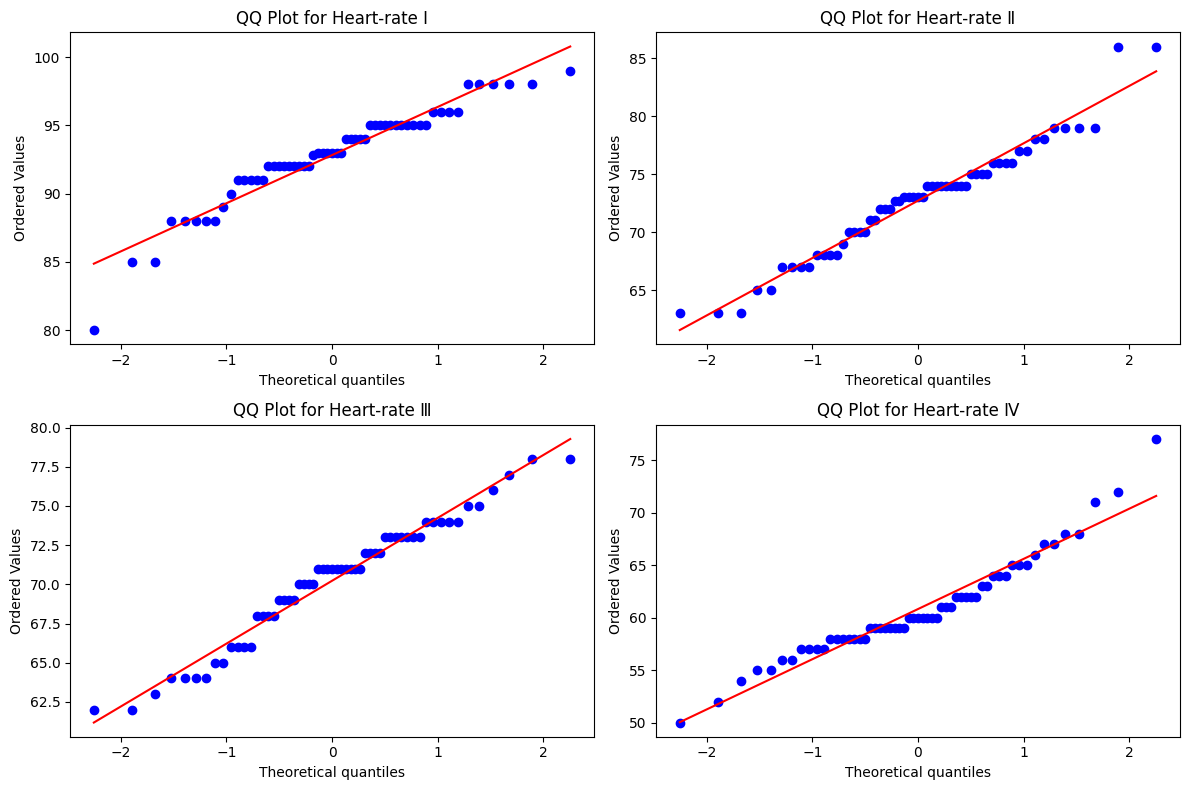

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
roman_labels = ['Heart-rate Ⅰ', 'Heart-rate Ⅱ', 'Heart-rate Ⅲ', 'Heart-rate Ⅳ']

plt.figure(figsize=(12, 8))

for i, (col, roman) in enumerate(zip(columns, roman_labels), 1):
    plt.subplot(2, 2, i) 
    stats.probplot(df_filled[col].dropna(), dist="norm", plot=plt) 
    plt.title(f'QQ Plot for {roman}') 

plt.tight_layout()
plt.show()

In [808]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.graph_objects as go

# Define the column names for Heart-rate
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
roman_labels = ['User Ⅰ', 'User Ⅱ', 'User Ⅲ', 'User Ⅳ']

def create_qq_plot(columns, title):
    fig = go.Figure()

    for col, roman in zip(columns, roman_labels):
        data = pd.to_numeric(df_filled[col], errors='coerce').dropna()  # Ensure numeric values only
        
        if data.empty:
            print(f"Warning: No valid numeric data for {roman}, skipping.")
            continue  # Skip if no valid data
        
        # Perform Q-Q plot calculation
        osm, osr = stats.probplot(data, dist="norm")[0]  # Extract only the quantiles

        # Add scatter plot for each user
        fig.add_trace(go.Scatter(
            x=osm, 
            y=osr, 
            mode='markers', 
            name=f'QQ Plot for {roman}',
            marker=dict(size=6, opacity=0.7)
        ))

    # Add reference (y=x) line
    if fig.data:
        min_val = min(fig.data[0].x)
        max_val = max(fig.data[0].x)
    else:
        min_val, max_val = 0, 1

    fig.add_trace(go.Scatter(
        x=[min_val, max_val], 
        y=[min_val, max_val], 
        mode='lines', 
        name='Reference Line',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Theoretical Quantiles",
        yaxis_title="Ordered Values",
        template="plotly_white"
    )

    fig.show()

# Generate QQ plots for metric

create_qq_plot(heart_rate_columns, "Interactive QQ Plot for Heart-rate")


### Anderson test for Heart rate

In [809]:
from scipy.stats import anderson

for col, roman in zip(columns, roman_labels):
    data = df_filled[col].dropna()
    result = anderson(data)
    print(f'Anderson-Darling test for {roman}: Statistic={result.statistic}, Critical Values={result.critical_values}, Significance={result.significance_level}')


Anderson-Darling test for User Ⅰ: Statistic=1.0990334663772856, Critical Values=[0.542 0.617 0.741 0.864 1.028], Significance=[15.  10.   5.   2.5  1. ]
Anderson-Darling test for User Ⅱ: Statistic=0.5862320962073468, Critical Values=[0.542 0.617 0.741 0.864 1.028], Significance=[15.  10.   5.   2.5  1. ]
Anderson-Darling test for User Ⅲ: Statistic=0.7389233774271347, Critical Values=[0.542 0.617 0.741 0.864 1.028], Significance=[15.  10.   5.   2.5  1. ]
Anderson-Darling test for User Ⅳ: Statistic=1.0328097021501037, Critical Values=[0.542 0.617 0.741 0.864 1.028], Significance=[15.  10.   5.   2.5  1. ]


### Interactive bar plot for Heart-rate

In [810]:
import pandas as pd
import plotly.express as px

# Define columns and labels
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Convert to numeric to avoid errors
for col in heart_rate_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Calculate means
heart_rate_means = [df_filled[col].mean() for col in heart_rate_columns]

# Create DataFrames for plotting
df_heart_rate = pd.DataFrame({'Person': roman_labels, 'Average Heart-rate': heart_rate_means})

# Interactive bar plot for Heart-rate
fig2 = px.bar(df_heart_rate, x='Person', y='Average Heart-rate', text='Average Heart-rate',
              title='Average Heart-rate per Person', template="plotly_dark",
              color='Average Heart-rate', color_continuous_scale='purples')

fig2.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig2.show()


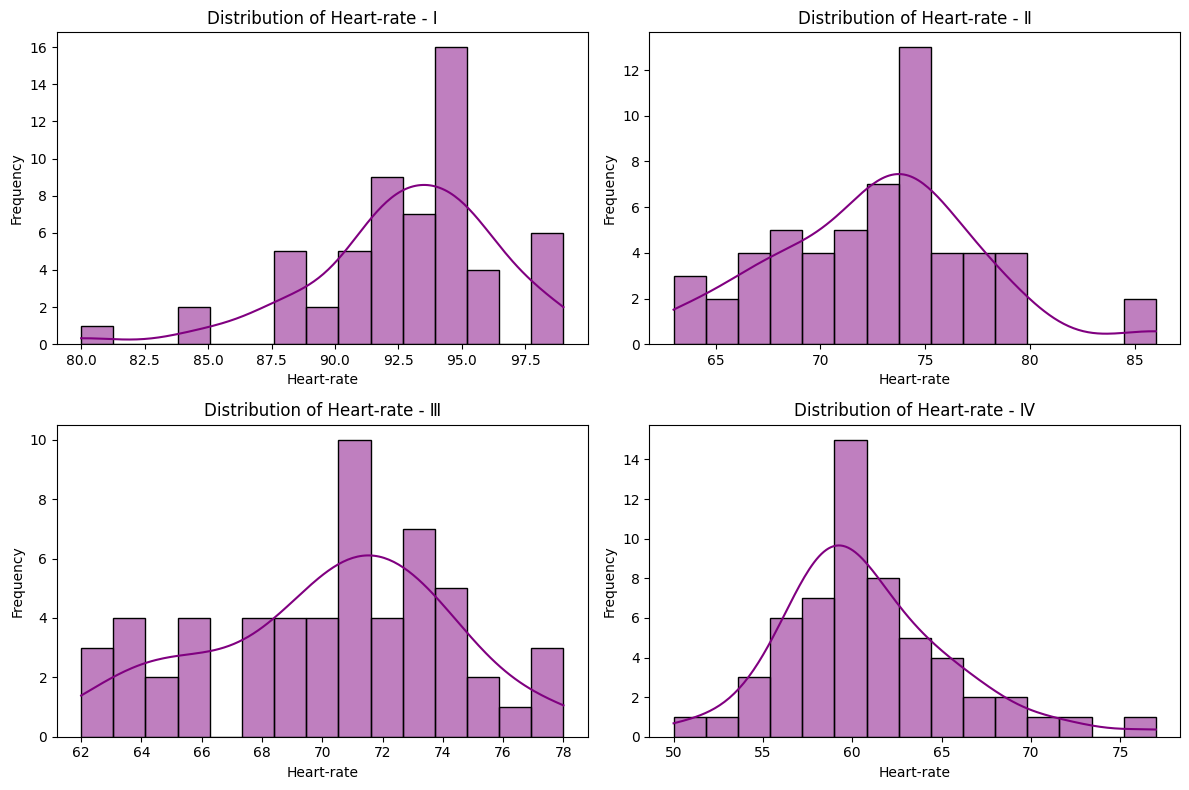

In [811]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define new columns
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Convert to numeric to avoid errors
for col in  heart_rate_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Plot Heart-rate
plt.figure(figsize=(12, 8))
for i, (col, roman) in enumerate(zip(heart_rate_columns, roman_labels), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filled[col], kde=True, bins=15, color='purple')
    plt.title(f'Distribution of Heart-rate - {roman}')
    plt.xlabel('Heart-rate')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Box plot for Heart rate

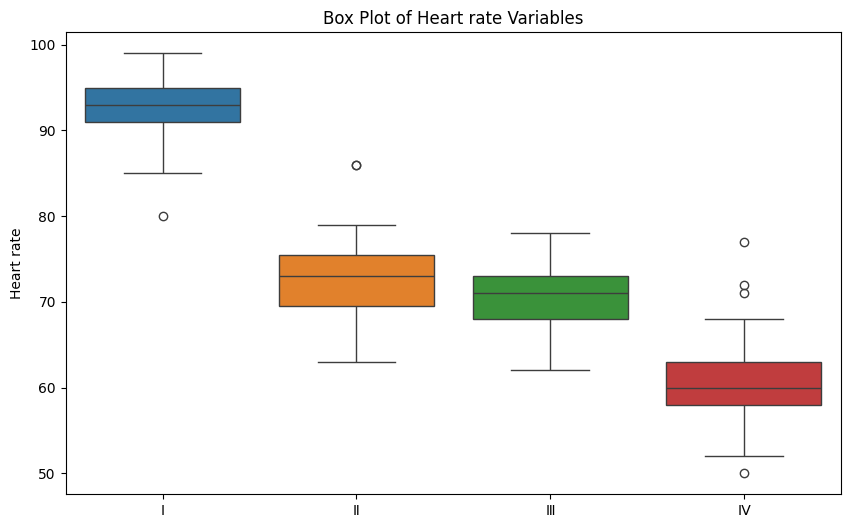

In [812]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Create a box plot for each weight column
sns.boxplot(data=df_DSPH[heart_rate_columns])

# Change x-axis labels to Greek numerals
plt.xticks(ticks=range(4), labels=roman_labels)

# Add title and labels
plt.title("Box Plot of Heart rate Variables")
plt.ylabel("Heart rate")

# Show the plot
plt.show()

###  **Interactive Summary Table for Heart rate**
### **Linear regression for Heart-rate**

In [813]:
import pandas as pd
import plotly.graph_objects as go
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import Output, VBox
from IPython.display import display

# Define column names for Heart-rate
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

fig = go.Figure()
summary_stats = []

# Creating dropdown options
dropdown_options = []
for i, (heart_col, roman) in enumerate(zip(heart_rate_columns, roman_labels)):
    heart_data = pd.to_numeric(df_filled[heart_col], errors='coerce').dropna()
    aligned_index = df_filled.index[df_filled[muscle_col].notna()]  # Keep only valid indices


    # Linear regression for Heart-rate
    if len(heart_data) > 1:
        heart_slope, heart_intercept, _, _, _ = stats.linregress(aligned_index, heart_data)
    else:
        heart_slope, heart_intercept = 0, heart_data.mean() if not heart_data.empty else 0

    # Summary Statistics
    summary_stats.append(
        pd.DataFrame({
            "Metric": ["Mean", "Std Dev", "Skewness", "Kurtosis", "Normality Test p-value"],
            "Heart-rate (bpm)": [heart_data.mean(), heart_data.std(), heart_data.skew(), heart_data.kurtosis(), stats.normaltest(heart_data).pvalue if len(heart_data) > 2 else None]
        })
    )

    # Scatter plot for Heart-rate
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=heart_data, 
        mode='markers', 
        name=f'Heart-rate {roman}',
        marker=dict(size=6, opacity=0.7, color='blue'),
        visible=(i == 0)
    ))

    # Regression line for Heart-rate
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=heart_slope * df_filled.index + heart_intercept,
        mode='lines',
        name=f'Heart-rate Regression {roman}',
        line=dict(dash='dash', color='blue'),
        visible=(i == 0)
    ))

    dropdown_options.append(
        dict(label=roman,
             method="update",
             args=[{"visible": [j // 4 == i for j in range(4 * len(roman_labels))]},
                   {"title": f"Scatter Plot & Regression - {roman}"}])
    )

fig.update_layout(
    title="Scatter Plot for Heart-rate",
    xaxis_title="Index (Time)",
    yaxis_title="Value",
    updatemenus=[dict(buttons=dropdown_options, direction="down", showactive=True)],
    template="plotly_white"
)

fig.show()

# **Interactive Summary Table**
# Dropdown Widget
dropdown = widgets.Dropdown(
    options=list(zip(roman_labels, range(len(roman_labels)))),
    description='User:',
    style={'description_width': 'initial'}
)

# Output Widget
out = Output()

# Function to update summary table
def update_summary(change):
    with out:
        out.clear_output(wait=True)
        display(summary_stats[change.new])

# Connect dropdown to function
dropdown.observe(update_summary, names='value')

# Show initial table
with out:
    display(summary_stats[0])

# Display Dropdown + Table
display(VBox([dropdown, out]))


### Mean Heart rate, Heart_rate Changes During Different Supplement Doses

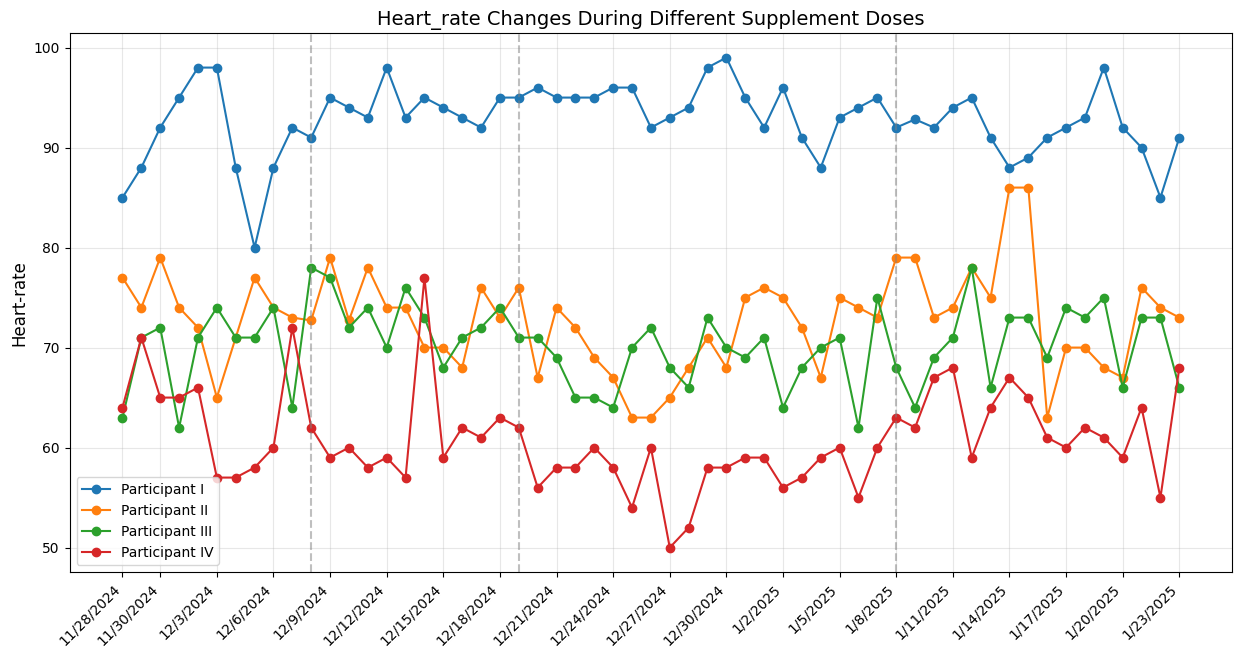

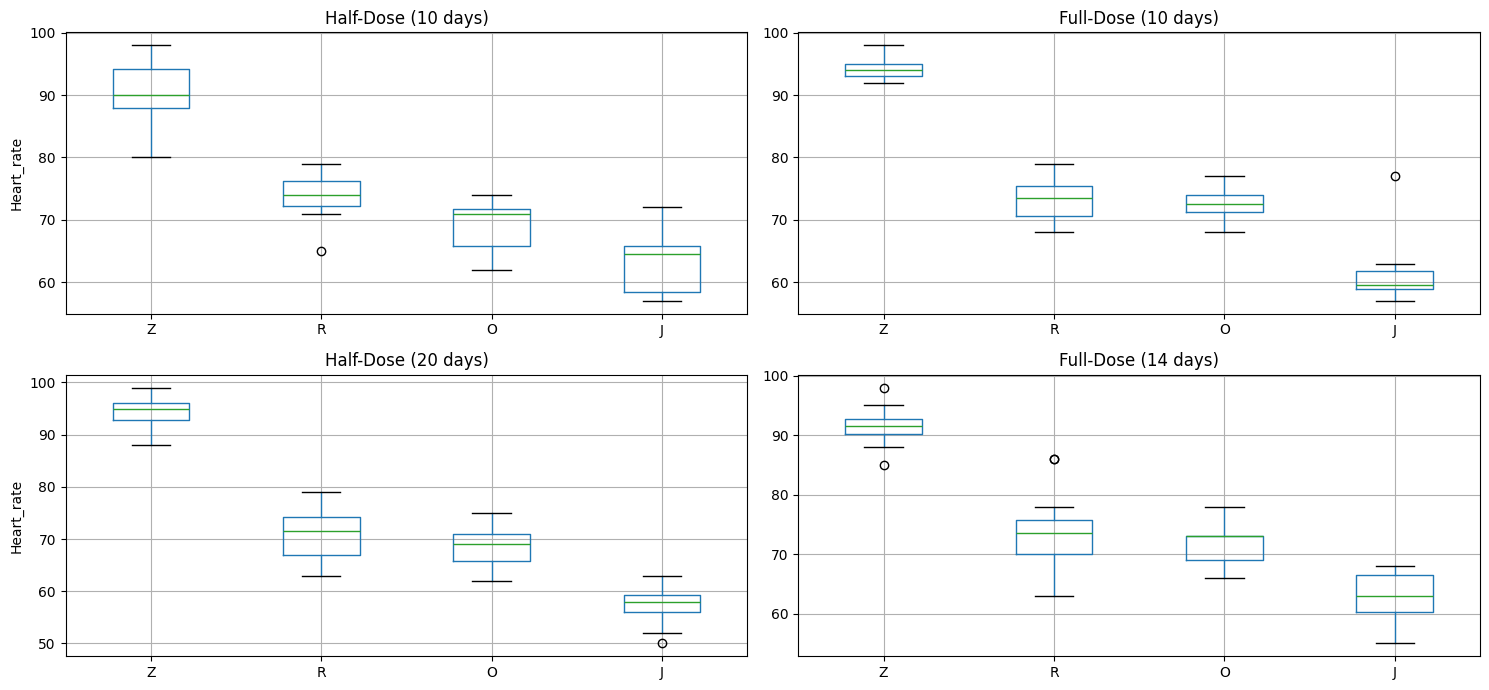

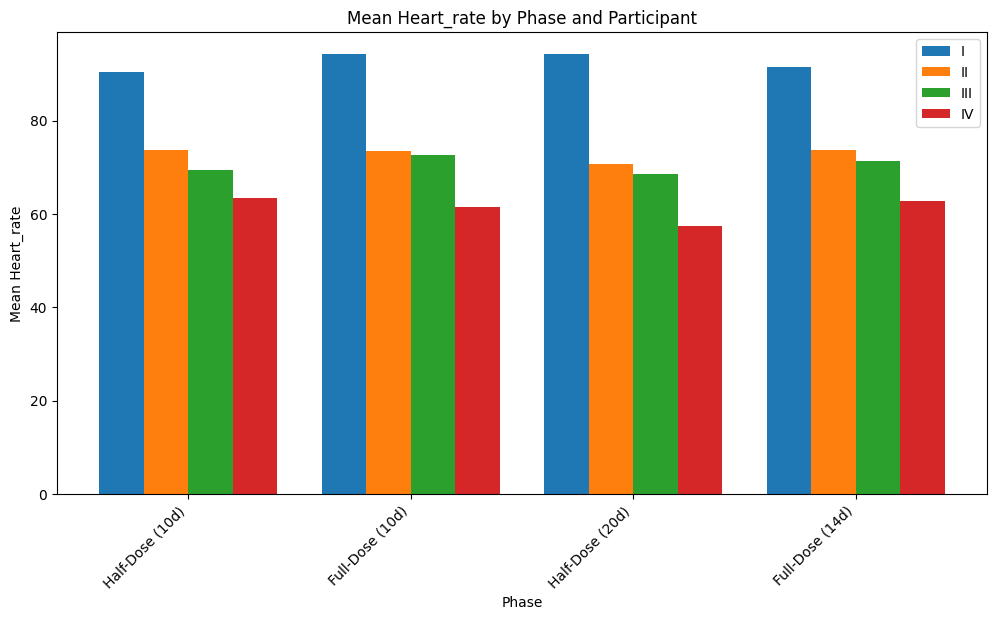

In [815]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Create Line Plot for all participants
Date = df_filled['Date']
Heart_rate_Z = df_filled['Heart-rate-Z']
Heart_rate_R = df_filled['Heart-rate-R']
Heart_rate_O = df_filled['Heart-rate-O']
Heart_rate_J = df_filled['Heart-rate-J']
plt.figure(figsize=(15, 7))
plt.plot(Date,Heart_rate_Z, label='Participant I', marker='o')
plt.plot(Date,Heart_rate_R, label='Participant II', marker='o')
plt.plot(Date, Heart_rate_O, label='Participant III', marker='o')
plt.plot(Date, Heart_rate_J, label='Participant IV', marker='o')

# Add phase separators and labels
phases = [0, 10, 21, 41, 61]  # Phase boundaries
phase_labels = ['Half-Dose\n(10d)', 'Full-Dose\n(10d)', 'Half-Dose\n(20d)', 'Full-Dose\n(14d)']
for p in phases[1:-1]:
    plt.axvline(x=p, color='gray', linestyle='--', alpha=0.5)

# Customize plot
plt.title('Heart_rate Changes During Different Supplement Doses', fontsize=14)
num_labels = 20
selected_indices = np.linspace(0, len(Date)-1, num_labels, dtype=int)

plt.xticks(selected_indices, Date[selected_indices], rotation=45, ha='right')
#plt.xlabel('Days', fontsize=12)
plt.ylabel('Heart-rate', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Box Plot for each phase and participant
# First, organize data by phases
phase1 = pd.DataFrame({
    'Z': Heart_rate_Z[:10],
    'R': Heart_rate_R[:10],
    'O': Heart_rate_O[:10],
    'J': Heart_rate_J[:10]
})

phase2 = pd.DataFrame({
    'Z': Heart_rate_Z[11:21],
    'R': Heart_rate_R[11:21],
    'O': Heart_rate_O[11:21],
    'J': Heart_rate_J[11:21]
})

phase3 = pd.DataFrame({
    'Z': Heart_rate_Z[22:42],
    'R': Heart_rate_R[22:42],
    'O': Heart_rate_O[22:42],
    'J': Heart_rate_J[22:42]
})

phase4 = pd.DataFrame({
    'Z': Heart_rate_Z[43:],
    'R': Heart_rate_R[43:],
    'O': Heart_rate_O[43:],
    'J': Heart_rate_J[43:]
})

plt.figure(figsize=(15, 7))
plt.subplot(2,2,1)
phase1.boxplot()
plt.title('Half-Dose (10 days)')
plt.ylabel('Heart_rate')

plt.subplot(2,2,2)
phase2.boxplot()
plt.title('Full-Dose (10 days)')

plt.subplot(2,2,3)
phase3.boxplot()
plt.title('Half-Dose (20 days)')
plt.ylabel('Heart_rate')

plt.subplot(2,2,4)
phase4.boxplot()
plt.title('Full-Dose (14 days)')

plt.tight_layout()
plt.show()

# 3. Mean Changes Plot
means_df = pd.DataFrame({
    'Phase': ['Half-Dose (10d)', 'Full-Dose (10d)', 'Half-Dose (20d)', 'Full-Dose (14d)'],
    'Z': [phase1['Z'].mean(), phase2['Z'].mean(), phase3['Z'].mean(), phase4['Z'].mean()],
    'R': [phase1['R'].mean(), phase2['R'].mean(), phase3['R'].mean(), phase4['R'].mean()],
    'O': [phase1['O'].mean(), phase2['O'].mean(), phase3['O'].mean(), phase4['O'].mean()],
    'J': [phase1['J'].mean(), phase2['J'].mean(), phase3['J'].mean(), phase4['J'].mean()]
})

plt.figure(figsize=(12, 6))
bar_width = 0.2
r1 = np.arange(len(means_df['Phase']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.bar(r1, means_df['Z'], width=bar_width, label='I')
plt.bar(r2, means_df['R'], width=bar_width, label='II')
plt.bar(r3, means_df['O'], width=bar_width, label='III')
plt.bar(r4, means_df['J'], width=bar_width, label='IV')

plt.xlabel('Phase')
plt.ylabel('Mean Heart_rate')
plt.title('Mean Heart_rate by Phase and Participant')
#plt.xticks([r + bar_width*1.5 for r in range(len(means_df['Phase']))], means_df['Phase'])
# Rotate x-axis labels
num_labels = 10
selected_indices = np.linspace(0, len(Date)-1, num_labels, dtype=int)
plt.xticks([r + bar_width*1.5 for r in range(len(means_df['Phase']))], 
         means_df['Phase'], rotation=45, ha="right")
plt.legend()
plt.show()


### Analyze_users for Heart rate

In [816]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import ipywidgets as widgets
from IPython.display import display

user_labels = ['I', 'II', 'III', 'VI']

def analyze_user(user_index):
    # Get the heart rate column for the selected user
    user_heart_rate = heart_rate_columns[user_index]

    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(12, 4))

    # Filter and clean the dataset
    user_data = df_filled[['Intake-Dose', user_heart_rate]].dropna()
    user_data = user_data[user_data['Intake-Dose'] != 'Break']
    user_data.rename(columns={user_heart_rate: 'Value', 'Intake-Dose': 'Phase'}, inplace=True)
    user_data['Phase'] = user_data['Phase'].str.strip()

    # Calculate the mean value per phase
    mean_values = user_data.groupby('Phase')['Value'].mean()

    # Plot bar chart of mean values
    bars = ax.bar(mean_values.index, mean_values.values, color=['blue', 'green', 'orange', 'red'])

    # Add numerical values on top of bars
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('Phase')
    ax.set_ylabel('Mean Value')
    ax.set_title(f'Heart-rate - User {user_labels[user_index]}')

    # Set x-axis labels and rotation
    ax.set_xticks(range(len(mean_values.index)))
    ax.set_xticklabels(mean_values.index, rotation=45)

    # Adjust y-axis limits for better visualization
    if len(mean_values) > 1:
        ax.set_ylim(min(mean_values) * 0.98, max(mean_values) * 1.02)
    else:
        ax.set_ylim(mean_values.iloc[0] * 0.95, mean_values.iloc[0] * 1.05)

    plt.tight_layout()
    plt.show()

    # ------------------ Statistical Tests ------------------
    print(f"\n**Statistical Analysis for User {user_labels[user_index]}**\n")

    # Normality Test (Anderson-Darling)
    normality_result = "Not enough data for Normality Test"
    if len(user_data['Value']) > 2:  
        ad_result = stats.anderson(user_data['Value'])
        normality_result = (
            f"Statistic = {ad_result.statistic:.4f}, Critical Value = {ad_result.critical_values[2]:.4f}, "
            f"Conclusion: {'Data is Normally Distributed' if ad_result.statistic < ad_result.critical_values[2] else 'Data is NOT Normally Distributed'}"
        )

    # Homogeneity Test (Levene's Test)
    phases = user_data['Phase'].unique()
    grouped_data = [user_data[user_data['Phase'] == phase]['Value'] for phase in phases if not user_data[user_data['Phase'] == phase].empty]
    homogeneity_result = "Not enough data for Variance Test"
    if len(grouped_data) > 1:
        levene_stat, levene_p = stats.levene(*grouped_data, center='median')
        homogeneity_result = (
            f"Levene Statistic = {levene_stat:.4f}, p-value = {levene_p:.4f}, "
            f"Conclusion: {'Variance is Homogeneous' if levene_p > 0.05 else 'Variance is NOT Homogeneous'}"
        )

    print(f"\n📌 **Heart Rate (bpm)**")
    print(f"🔹 **Normality Test:** {normality_result}")
    print(f"🔹 **Variance Homogeneity Test:** {homogeneity_result}")

# Define heart rate column names
heart_rate_columns = ['Heart-rate-Z', 'Heart-rate-R', 'Heart-rate-O', 'Heart-rate-J']

# Create a dropdown widget for user selection
user_dropdown = widgets.Dropdown(
    options=[(f'User {label}', i) for i, label in enumerate(user_labels)],
    description='Select User:',
    style={'description_width': 'initial'}
)

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(analyze_user, user_index=user_dropdown)


Dropdown(description='Select User:', options=(('User I', 0), ('User II', 1), ('User III', 2), ('User VI', 3)),…

interactive(children=(Dropdown(description='Select User:', options=(('User I', 0), ('User II', 1), ('User III'…

### Heatmap for Heart rate

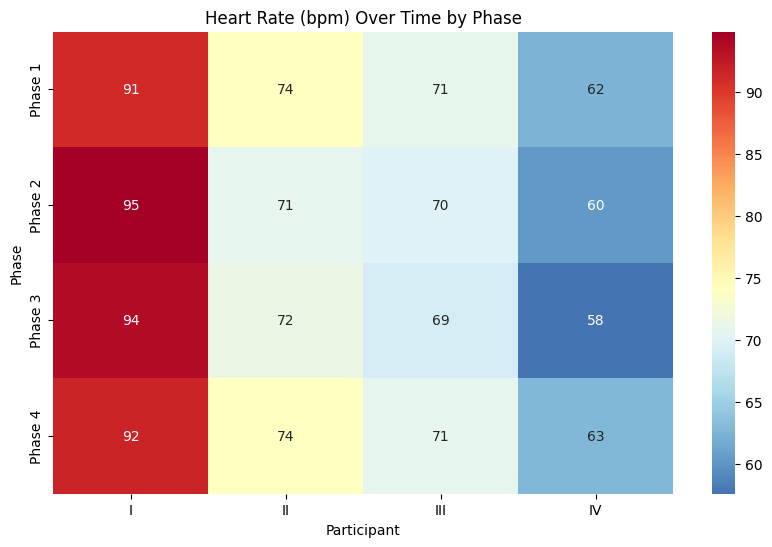

In [817]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

df_filled.columns = df_filled.columns.str.strip()  # Clean column names

# Define column names for each metric
Heart_rate_columns = [
    'Heart-rate-Z', 
    'Heart-rate-R', 
    'Heart-rate-O', 
    'Heart-rate-J'
]

# Convert blood pressure columns to numeric
for col in Heart_rate_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Determine the number of rows per phase (splitting equally)
num_rows = len(df_filled)
phase_size = num_rows // 4  # Assuming equal division into 4 phases

# Creating a DataFrame with phases
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phases = np.repeat(phase_labels, phase_size)

# Adjust for cases where num_rows is not a multiple of 4
if len(phases) < num_rows:
    phases = np.append(phases, ['Phase 4'] * (num_rows - len(phases)))

# Creating the DataFrame with actual blood pressure values
df_phases = pd.DataFrame({
    'Phase': phases[:num_rows],  # Ensuring correct length
    'I': df_filled['Heart-rate-Z'],
    'II': df_filled['Heart-rate-R'],
    'III': df_filled['Heart-rate-O'],
    'IV': df_filled['Heart-rate-J']
})

# Pivot the DataFrame for heatmap
heatmap_data = df_phases.groupby('Phase').mean()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='RdYlBu_r', annot=True, center=np.mean(heatmap_data.values))
plt.title('Heart Rate (bpm) Over Time by Phase')
plt.xlabel('Participant')
plt.ylabel('Phase')
plt.show()

### Blood Pressure(systolic) (mmHg) and Blood Pressure(diastolic) (mmHg)


### QQ Plot for Blood pressure

<Figure size 1200x800 with 0 Axes>

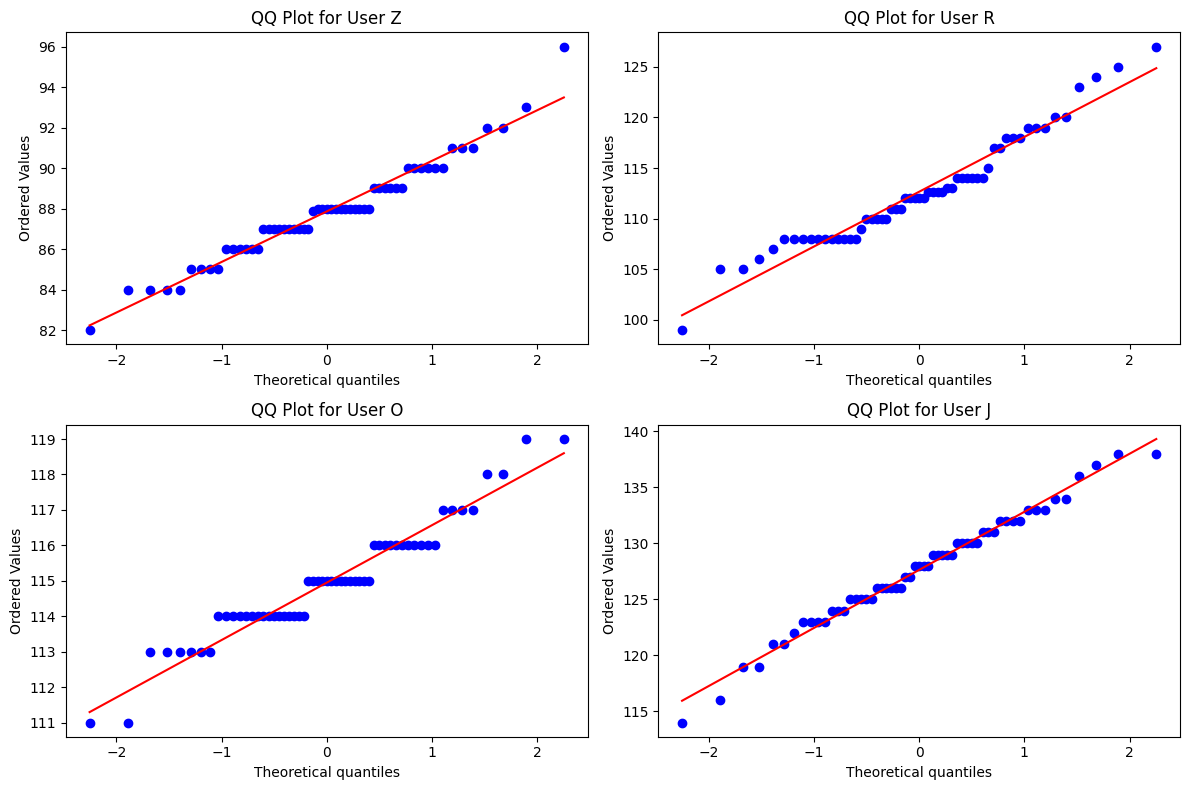

<Figure size 1200x800 with 0 Axes>

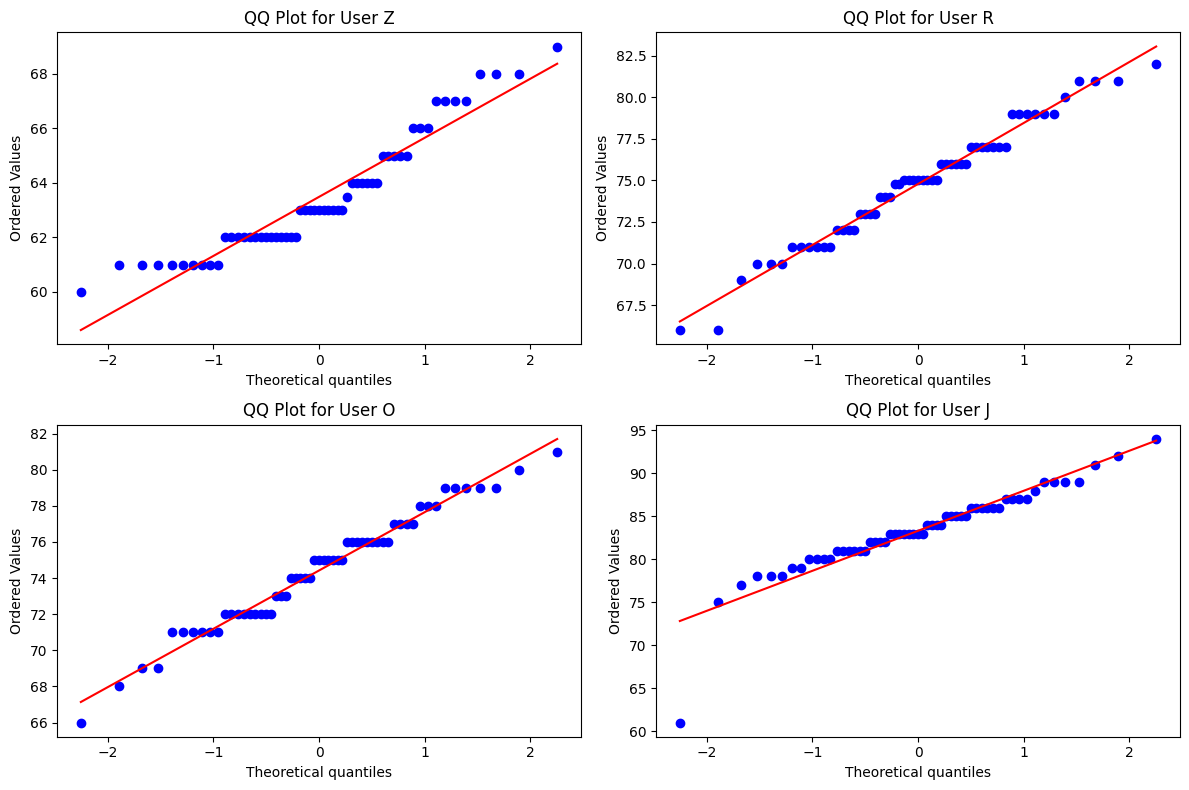

In [819]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Define column names for each metric
systolic_bp_columns = [
    'Blood-Pressure(systolic)(mmHg)-Z', 
    'Blood-Pressure(systolic)(mmHg)-R', 
    'Blood-Pressure(systolic)(mmHg)-O', 
    'Blood-Pressure(systolic)(mmHg)-J'
]

diastolic_bp_columns = [
    'Blood-Pressure(diastolic)(mmHg)-Z', 
    'Blood-Pressure(diastolic)(mmHg)-R', 
    'Blood-Pressure(diastolic)(mmHg)-O', 
    'Blood-Pressure(diastolic)(mmHg)-J'
]
roman_labels = ['User Z', 'User R', 'User O', 'User J']  # Ensuring correct mapping

plt.figure(figsize=(12, 8))

plt.figure(figsize=(12, 8))

for i, (col, roman) in enumerate(zip(systolic_bp_columns, roman_labels), 1):
    plt.subplot(2, 2, i) 
    stats.probplot(df_filled[col].dropna(), dist="norm", plot=plt) 
    plt.title(f'QQ Plot for {roman}') 

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

plt.figure(figsize=(12, 8))

for i, (col, roman) in enumerate(zip(diastolic_bp_columns, roman_labels), 1):
    plt.subplot(2, 2, i) 
    stats.probplot(df_filled[col].dropna(), dist="norm", plot=plt) 
    plt.title(f'QQ Plot for {roman}') 

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import scipy.stats as stats
import plotly.graph_objects as go

# Define column names for each metric
systolic_bp_columns = [
    'Blood-Pressure(systolic)(mmHg)-Z', 
    'Blood-Pressure(systolic)(mmHg)-R', 
    'Blood-Pressure(systolic)(mmHg)-O', 
    'Blood-Pressure(systolic)(mmHg)-J'
]

diastolic_bp_columns = [
    'Blood-Pressure(diastolic)(mmHg)-Z', 
    'Blood-Pressure(diastolic)(mmHg)-R', 
    'Blood-Pressure(diastolic)(mmHg)-O', 
    'Blood-Pressure(diastolic)(mmHg)-J'
]

roman_labels = ['User Z', 'User R', 'User O', 'User J']  # Ensuring correct mapping

def create_qq_plot(columns, title, df):
    fig = go.Figure()
    has_data = False  # Track if we add any data to the plot
    all_x_values = []  # Store all x-values for dynamic scaling
    all_y_values = []  # Store all y-values for dynamic scaling

    for col, roman in zip(columns, roman_labels):
        if col not in df.columns:
            print(f"Warning: Column {col} not found in DataFrame, skipping.")
            continue
        
        data = df[col].dropna()
 
        if data.empty:
            print(f"Warning: No valid numeric data for {roman}, skipping.")
            continue  # Skip if no valid data
        
        has_data = True
        
        # Perform Q-Q plot calculation without standardization
        osm, osr = stats.probplot(data, dist="norm")[0]  # Extract only the quantiles
        all_x_values.extend(osm)
        all_y_values.extend(osr)
        # Add scatter plot for each user
        fig.add_trace(go.Scatter(
            x=osm, 
            y=osr, 
            mode='markers', 
            name=f'QQ Plot for {roman}',
            marker=dict(size=8, opacity=0.7, symbol='circle')
        ))

    if not has_data:
        print(f"No valid data for {title}, skipping plot.")
        return  # Do not create an empty plot

    # Adjust X and Y axis dynamically based on real data
    min_x, max_x = min(all_x_values), max(all_x_values)
    min_y, max_y = min(all_y_values), max(all_y_values)

    # Add reference (y=x) line
    fig.add_trace(go.Scatter(
        x=[min_x, max_x], 
        y=[min_x, max_x], 
        mode='lines', 
        name='Reference Line',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Theoretical Quantiles",
        yaxis_title="Ordered Values",
        xaxis=dict(range=[min_x, max_x]),
        yaxis=dict(range=[min_y, max_y]),
        template="plotly_white"
    )
    
    #print(f"Displaying {title}...")  # Debugging
    fig.show()


# Ensure only valid columns are processed
df.columns = df.columns.str.strip()
systolic_bp_columns = [col for col in systolic_bp_columns if col in df.columns]
diastolic_bp_columns = [col for col in diastolic_bp_columns if col in df.columns]

# Generate and separately display both plots
create_qq_plot(systolic_bp_columns, "QQ Plot for Systolic Blood Pressure", df)
create_qq_plot(diastolic_bp_columns, "QQ Plot for Diastolic Blood Pressure", df)



In [ ]:
print(df_filled[systolic_bp_columns].mean())  
print(df_filled[diastolic_bp_columns].mean())


Blood-Pressure(systolic)(mmHg)-Z     87.857143
Blood-Pressure(systolic)(mmHg)-R    112.660377
Blood-Pressure(systolic)(mmHg)-O    114.947368
Blood-Pressure(systolic)(mmHg)-J    127.631579
dtype: float64
Blood-Pressure(diastolic)(mmHg)-Z    63.482143
Blood-Pressure(diastolic)(mmHg)-R    74.781818
Blood-Pressure(diastolic)(mmHg)-O    74.421053
Blood-Pressure(diastolic)(mmHg)-J    83.315789
dtype: float64


In [ ]:
import pandas as pd
import plotly.express as px

# Load the dataset

df_filled.columns = df_filled.columns.str.strip()  # Clean column names

# Define columns for blood pressure
# Define column names for each metric
systolic_bp_columns = [
    'Blood-Pressure(systolic)(mmHg)-Z', 
    'Blood-Pressure(systolic)(mmHg)-R', 
    'Blood-Pressure(systolic)(mmHg)-O', 
    'Blood-Pressure(systolic)(mmHg)-J'
]

diastolic_bp_columns = [
    'Blood-Pressure(diastolic)(mmHg)-Z', 
    'Blood-Pressure(diastolic)(mmHg)-R', 
    'Blood-Pressure(diastolic)(mmHg)-O', 
    'Blood-Pressure(diastolic)(mmHg)-J'
]

roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Check if columns exist in the dataset
missing_cols = [col for col in systolic_bp_columns + diastolic_bp_columns if col not in df_filled.columns]
if missing_cols:
    print(f"Warning: Missing columns in dataset: {missing_cols}")
else:
    print("All required columns are present.")

# Convert columns to numeric values
for col in systolic_bp_columns + diastolic_bp_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Calculate means for each user and handle NaN values
systolic_means = [df_filled[col].mean() if col in df_filled else None for col in systolic_bp_columns]
diastolic_means = [df_filled[col].mean() if col in df_filled else None for col in diastolic_bp_columns]

# Replace NaN values with 0 for visualization
systolic_means = [0 if pd.isna(val) else val for val in systolic_means]
diastolic_means = [0 if pd.isna(val) else val for val in diastolic_means]

# Create DataFrames for visualization
df_systolic = pd.DataFrame({'Person': roman_labels, 'Systolic BP (mmHg)': systolic_means})
df_diastolic = pd.DataFrame({'Person': roman_labels, 'Diastolic BP (mmHg)': diastolic_means})

# Interactive bar plot for Systolic Blood Pressure
fig_systolic = px.bar(df_systolic, x='Person', y='Systolic BP (mmHg)', text='Systolic BP (mmHg)',
                      title='Average Systolic Blood Pressure (mmHg) per Person', template="plotly_dark",
                      color='Systolic BP (mmHg)', color_continuous_scale='reds')

fig_systolic.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_systolic.show()

# Interactive bar plot for Diastolic Blood Pressure
fig_diastolic = px.bar(df_diastolic, x='Person', y='Diastolic BP (mmHg)', text='Diastolic BP (mmHg)',
                       title='Average Diastolic Blood Pressure (mmHg) per Person', template="plotly_dark",
                       color='Diastolic BP (mmHg)', color_continuous_scale='blues')

fig_diastolic.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_diastolic.show()


All required columns are present.


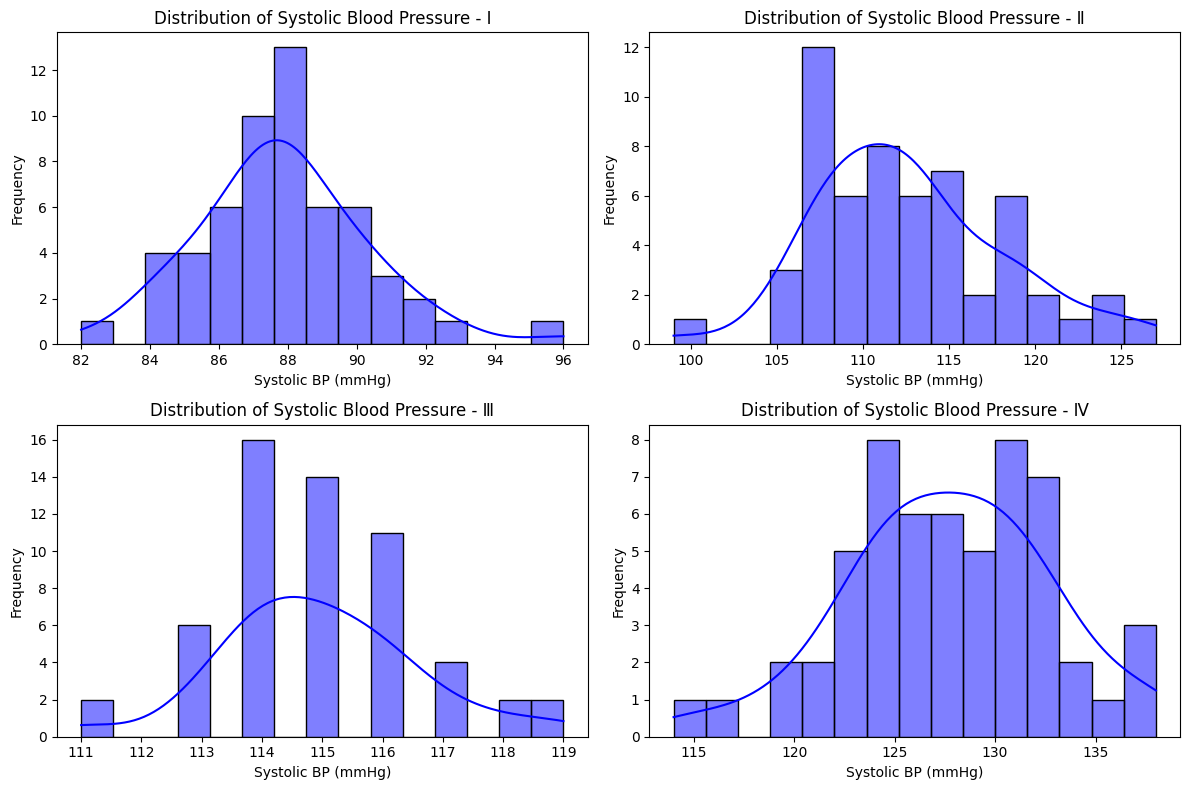

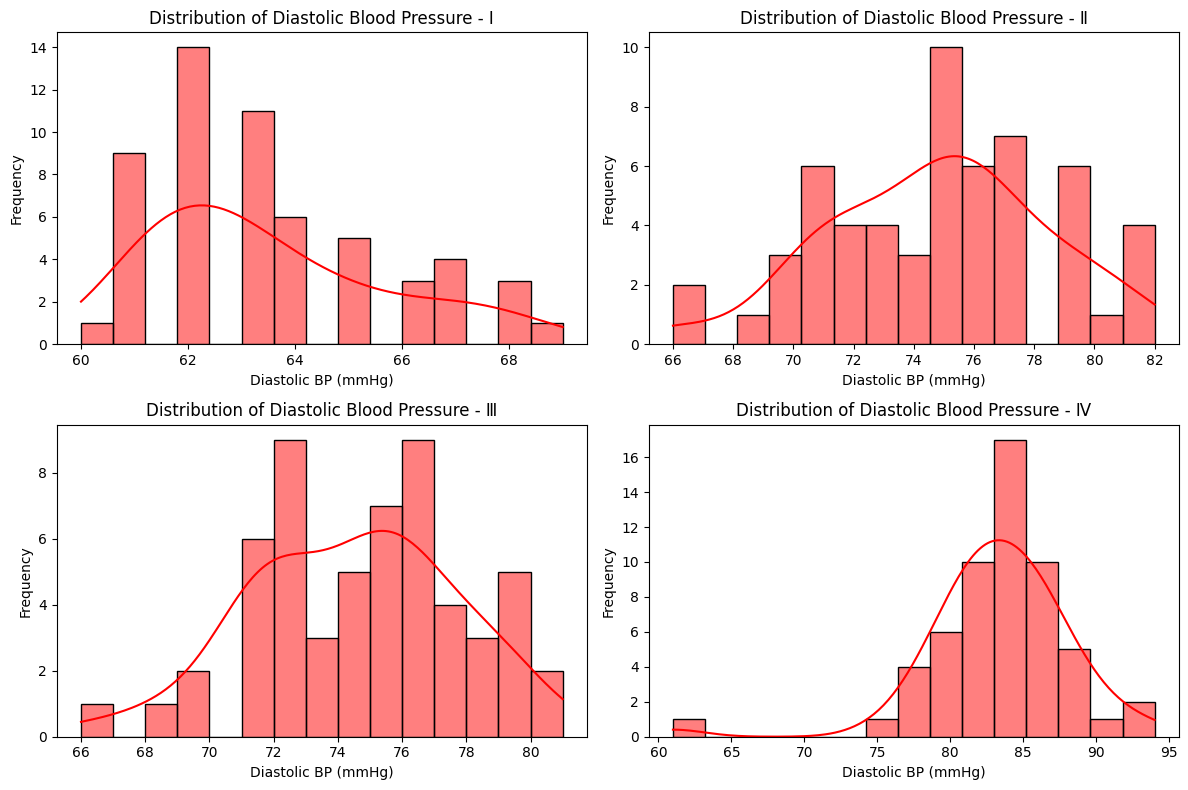

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define new columns
systolic_columns = ['Blood-Pressure(systolic)(mmHg)-Z', 'Blood-Pressure(systolic)(mmHg)-R', 'Blood-Pressure(systolic)(mmHg)-O', 'Blood-Pressure(systolic)(mmHg)-J']
diastolic_columns = ['Blood-Pressure(diastolic)(mmHg)-Z', 'Blood-Pressure(diastolic)(mmHg)-R', 'Blood-Pressure(diastolic)(mmHg)-O', 'Blood-Pressure(diastolic)(mmHg)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Convert to numeric to avoid errors
for col in systolic_columns + diastolic_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# 🔵 Plot Blood Pressure (Systolic)
plt.figure(figsize=(12, 8))
for i, (col, roman) in enumerate(zip(systolic_columns, roman_labels), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filled[col], kde=True, bins=15, color='blue')
    plt.title(f'Distribution of Systolic Blood Pressure - {roman}')
    plt.xlabel('Systolic BP (mmHg)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 🔴 Plot Blood Pressure (Diastolic)
plt.figure(figsize=(12, 8))
for i, (col, roman) in enumerate(zip(diastolic_columns, roman_labels), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filled[col], kde=True, bins=15, color='red')
    plt.title(f'Distribution of Diastolic Blood Pressure - {roman}')
    plt.xlabel('Diastolic BP (mmHg)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import scipy.stats as stats
from ipywidgets import widgets, Output, VBox
from IPython.display import display

# Define column names for Blood Pressure (Systolic & Diastolic)
systolic_columns = ['Blood-Pressure(systolic)(mmHg)-Z', 'Blood-Pressure(systolic)(mmHg)-R', 'Blood-Pressure(systolic)(mmHg)-O', 'Blood-Pressure(systolic)(mmHg)-J']
diastolic_columns = ['Blood-Pressure(diastolic)(mmHg)-Z', 'Blood-Pressure(diastolic)(mmHg)-R', 'Blood-Pressure(diastolic)(mmHg)-O', 'Blood-Pressure(diastolic)(mmHg)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

fig = go.Figure()
summary_stats = []

# Creating dropdown options
dropdown_options = []
for i, (sys_col, dia_col, roman) in enumerate(zip(systolic_columns, diastolic_columns, roman_labels)):
    sys_data = df_filled[sys_col].dropna()
    dia_data = df_filled[dia_col].dropna()
    aligned_index = df_filled.index[df_filled[sys_col].notna()]  # Keep only valid indices

    # Linear regression for Systolic BP
    sys_slope, sys_intercept, _, _, _ = stats.linregress(aligned_index, sys_data)
    
    # Linear regression for Diastolic BP
    dia_slope, dia_intercept, _, _, _ = stats.linregress(aligned_index, dia_data)

    # Summary Statistics
    summary_stats.append(
        pd.DataFrame({
            "Metric": ["Mean", "Std Dev", "Skewness", "Kurtosis", "Normality Test p-value"],
            "Systolic BP (mmHg)": [sys_data.mean(), sys_data.std(), sys_data.skew(), sys_data.kurtosis(), stats.normaltest(sys_data).pvalue],
            "Diastolic BP (mmHg)": [dia_data.mean(), dia_data.std(), dia_data.skew(), dia_data.kurtosis(), stats.normaltest(dia_data).pvalue]
        })
    )

    # Scatter plot for Systolic BP
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=sys_data, 
        mode='markers', 
        name=f'Systolic BP {roman}',
        marker=dict(size=6, opacity=0.7, color='red'),
        visible=(i == 0)  # Show only first user initially
    ))

    # Regression line for Systolic BP
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=sys_slope * df_filled.index + sys_intercept,
        mode='lines',
        name=f'Systolic BP Regression {roman}',
        line=dict(dash='dash', color='red'),
        visible=(i == 0)
    ))

    # Scatter plot for Diastolic BP
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=dia_data, 
        mode='markers', 
        name=f'Diastolic BP {roman}',
        marker=dict(size=6, opacity=0.7, color='blue'),
        visible=(i == 0)
    ))

    # Regression line for Diastolic BP
    fig.add_trace(go.Scatter(
        x=df_filled.index, 
        y=dia_slope * df_filled.index + dia_intercept,
        mode='lines',
        name=f'Diastolic BP Regression {roman}',
        line=dict(dash='dash', color='blue'),
        visible=(i == 0)
    ))

    dropdown_options.append(
        dict(label=roman,
             method="update",
             args=[{"visible": [j // 4 == i for j in range(4 * len(roman_labels))]},
                   {"title": f"Scatter Plot & Regression - {roman}"}])
    )

fig.update_layout(
    title="Scatter Plot & Regression with Dropdown (Blood Pressure)",
    xaxis_title="Index (Time)",
    yaxis_title="Blood Pressure (mmHg)",
    updatemenus=[dict(buttons=dropdown_options, direction="down", showactive=True)],
    template="plotly_white"
)

fig.show()

# **Interactive Summary Table**
# Dropdown Widget
dropdown = widgets.Dropdown(
    options=list(zip(roman_labels, range(len(roman_labels)))),
    description='User:',
    style={'description_width': 'initial'}
)

# Output Widget
out = Output()

# Function to update summary table
def update_summary(change):
    with out:
        out.clear_output(wait=True)
        display(summary_stats[change.new])

# Connect dropdown to function
dropdown.observe(update_summary, names='value')

# Show initial table
with out:
    display(summary_stats[0])

# Display Dropdown + Table
display(VBox([dropdown, out]))


### Box plot for blood prussure

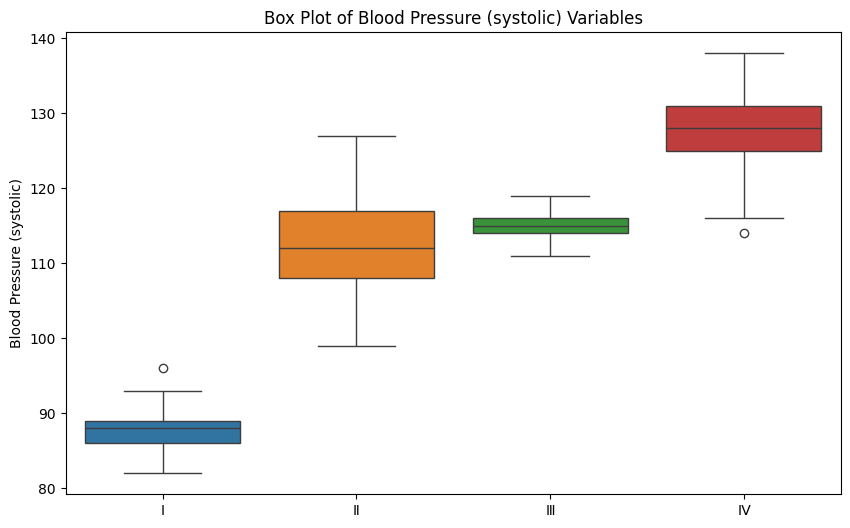

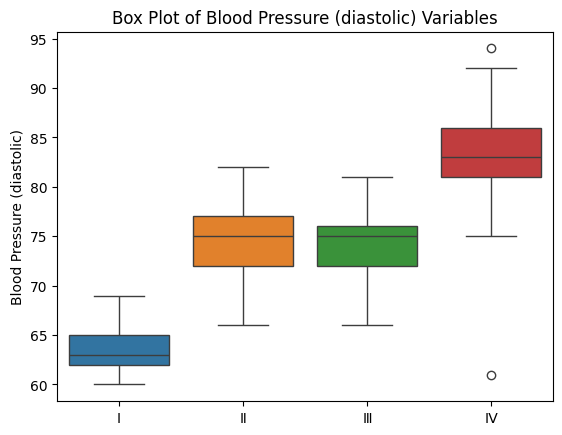

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Define column names for Blood Pressure (Systolic & Diastolic)
systolic_columns = ['Blood-Pressure(systolic)(mmHg)-Z', 'Blood-Pressure(systolic)(mmHg)-R', 'Blood-Pressure(systolic)(mmHg)-O', 'Blood-Pressure(systolic)(mmHg)-J']
diastolic_columns = ['Blood-Pressure(diastolic)(mmHg)-Z', 'Blood-Pressure(diastolic)(mmHg)-R', 'Blood-Pressure(diastolic)(mmHg)-O', 'Blood-Pressure(diastolic)(mmHg)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Create a box plot for each Pressure (systolic) 
sns.boxplot(data=df_DSPH[systolic_columns])
# Change x-axis labels to Greek numerals
plt.xticks(ticks=range(4), labels=roman_labels)
# Add title and labels
plt.title("Box Plot of Blood Pressure (systolic) Variables")
plt.ylabel("Blood Pressure (systolic)")
# Show the plot
plt.show()


# Create a box plot for each Pressure (diastolic)
sns.boxplot(data=df_DSPH[diastolic_columns])
# Change x-axis labels to Greek numerals
plt.xticks(ticks=range(4), labels=roman_labels)
# Add title and labels
plt.title("Box Plot of Blood Pressure (diastolic) Variables")
plt.ylabel("Blood Pressure (diastolic)")
# Show the plot
plt.show()



### Blood Pressure Changes During Different Supplement Doses

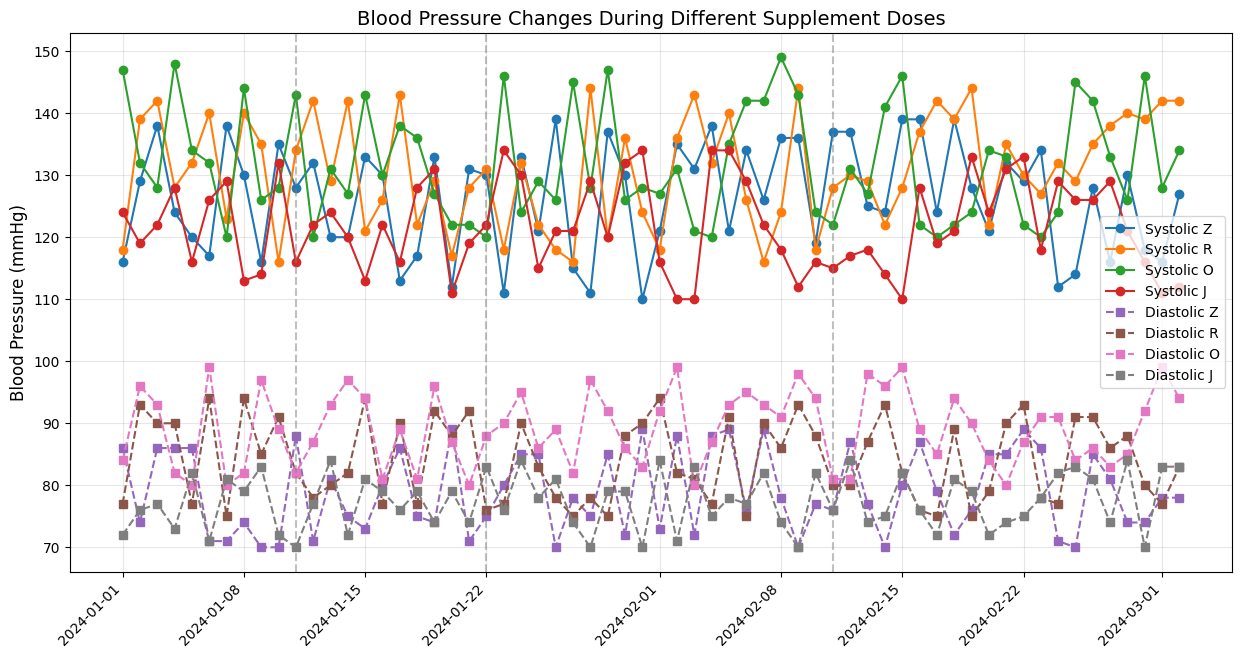

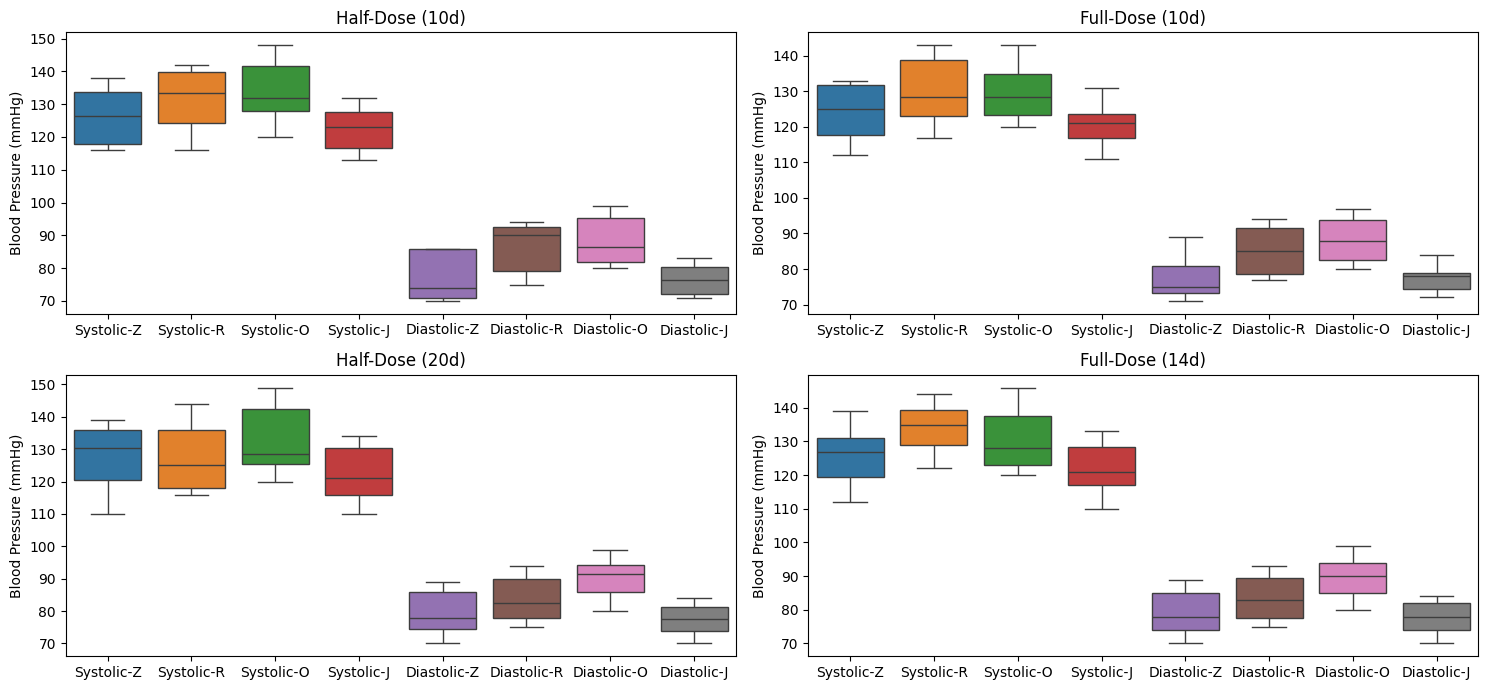

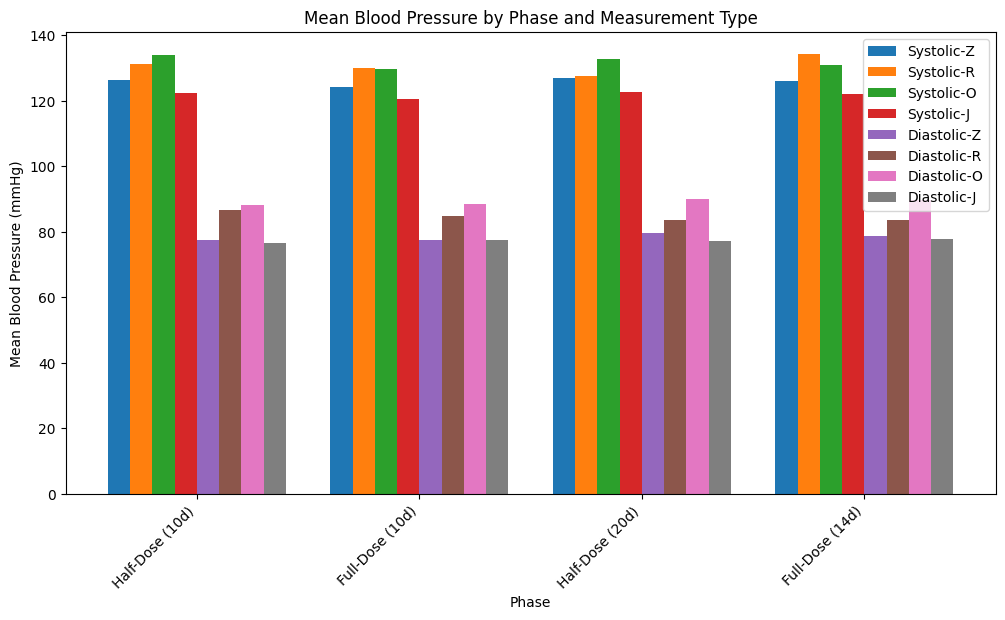

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated data
dates = pd.date_range(start="2024-01-01", periods=62, freq="D")

# Random blood pressure data for 4 participants
np.random.seed(42)
BP_sys_Z = np.random.randint(110, 140, size=len(dates))
BP_sys_R = np.random.randint(115, 145, size=len(dates))
BP_sys_O = np.random.randint(120, 150, size=len(dates))
BP_sys_J = np.random.randint(110, 135, size=len(dates))

BP_dia_Z = np.random.randint(70, 90, size=len(dates))
BP_dia_R = np.random.randint(75, 95, size=len(dates))
BP_dia_O = np.random.randint(80, 100, size=len(dates))
BP_dia_J = np.random.randint(70, 85, size=len(dates))

# 1. Line Plot for Blood Pressure Changes
plt.figure(figsize=(15, 7))
plt.plot(dates, BP_sys_Z, label='Systolic Z', marker='o')
plt.plot(dates, BP_sys_R, label='Systolic R', marker='o')
plt.plot(dates, BP_sys_O, label='Systolic O', marker='o')
plt.plot(dates, BP_sys_J, label='Systolic J', marker='o')

plt.plot(dates, BP_dia_Z, label='Diastolic Z', linestyle='dashed', marker='s')
plt.plot(dates, BP_dia_R, label='Diastolic R', linestyle='dashed', marker='s')
plt.plot(dates, BP_dia_O, label='Diastolic O', linestyle='dashed', marker='s')
plt.plot(dates, BP_dia_J, label='Diastolic J', linestyle='dashed', marker='s')

# Add phase separators and labels
phases = [0, 10, 21, 41, 61]  
phase_labels = ['Half-Dose\n(10d)', 'Full-Dose\n(10d)', 'Half-Dose\n(20d)', 'Full-Dose\n(14d)']
for p in phases[1:-1]:
    plt.axvline(x=dates[p], color='gray', linestyle='--', alpha=0.5)

plt.title('Blood Pressure Changes During Different Supplement Doses', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Blood Pressure (mmHg)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Box Plot for Blood Pressure in Different Phases
phases_dict = {
    'Half-Dose (10d)': slice(0, 10),
    'Full-Dose (10d)': slice(11, 21),
    'Half-Dose (20d)': slice(22, 42),
    'Full-Dose (14d)': slice(43, None)
}

plt.figure(figsize=(15, 7))
for i, (phase, index) in enumerate(phases_dict.items(), 1):
    plt.subplot(2, 2, i)
    phase_data = pd.DataFrame({
        'Systolic-Z': BP_sys_Z[index], 'Systolic-R': BP_sys_R[index],
        'Systolic-O': BP_sys_O[index], 'Systolic-J': BP_sys_J[index],
        'Diastolic-Z': BP_dia_Z[index], 'Diastolic-R': BP_dia_R[index],
        'Diastolic-O': BP_dia_O[index], 'Diastolic-J': BP_dia_J[index]
    })
    sns.boxplot(data=phase_data)
    plt.title(phase)
    plt.ylabel('Blood Pressure (mmHg)')

plt.tight_layout()
plt.show()

# 3. Mean Blood Pressure Changes
mean_bp = {
    'Phase': list(phases_dict.keys()),
    'Systolic-Z': [BP_sys_Z[index].mean() for index in phases_dict.values()],
    'Systolic-R': [BP_sys_R[index].mean() for index in phases_dict.values()],
    'Systolic-O': [BP_sys_O[index].mean() for index in phases_dict.values()],
    'Systolic-J': [BP_sys_J[index].mean() for index in phases_dict.values()],
    'Diastolic-Z': [BP_dia_Z[index].mean() for index in phases_dict.values()],
    'Diastolic-R': [BP_dia_R[index].mean() for index in phases_dict.values()],
    'Diastolic-O': [BP_dia_O[index].mean() for index in phases_dict.values()],
    'Diastolic-J': [BP_dia_J[index].mean() for index in phases_dict.values()]
}

means_df = pd.DataFrame(mean_bp)

plt.figure(figsize=(12, 6))
bar_width = 0.1
r1 = np.arange(len(means_df['Phase']))
r_positions = [r1 + i*bar_width for i in range(8)]

for i, col in enumerate(means_df.columns[1:]):
    plt.bar(r_positions[i], means_df[col], width=bar_width, label=col)

plt.xlabel('Phase')
plt.ylabel('Mean Blood Pressure (mmHg)')
plt.title('Mean Blood Pressure by Phase and Measurement Type')
plt.xticks(r1 + (bar_width*3.5), means_df['Phase'], rotation=45, ha="right")
plt.legend()
plt.show()


### Analyze_user for blood prussure (Systolic, Diastolic)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import ipywidgets as widgets
from IPython.display import display

# User labels corresponding to blood pressure readings
user_labels = ['I', 'II', 'III', 'VI']

# Define systolic and diastolic blood pressure columns
systolic_columns = ['Blood-Pressure(systolic)(mmHg)-Z', 'Blood-Pressure(systolic)(mmHg)-R',
                    'Blood-Pressure(systolic)(mmHg)-O', 'Blood-Pressure(systolic)(mmHg)-J']

diastolic_columns = ['Blood-Pressure(diastolic)(mmHg)-Z', 'Blood-Pressure(diastolic)(mmHg)-R',
                     'Blood-Pressure(diastolic)(mmHg)-O', 'Blood-Pressure(diastolic)(mmHg)-J']

def analyze_user_bp(user_index):
    # Get the systolic and diastolic BP columns for the selected user
    user_systolic = systolic_columns[user_index]
    user_diastolic = diastolic_columns[user_index]

    # Create a figure with two subplots (systolic and diastolic)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Filter and clean the dataset
    user_data = df_filled[['Intake-Dose', user_systolic, user_diastolic]].dropna()
    user_data = user_data[user_data['Intake-Dose'] != 'Break']
    user_data.rename(columns={user_systolic: 'Systolic', user_diastolic: 'Diastolic', 'Intake-Dose': 'Phase'}, inplace=True)
    user_data['Phase'] = user_data['Phase'].str.strip()

    # Calculate mean values per phase
    mean_systolic = user_data.groupby('Phase')['Systolic'].mean()
    mean_diastolic = user_data.groupby('Phase')['Diastolic'].mean()

    # Plot systolic BP
    bars1 = ax[0].bar(mean_systolic.index, mean_systolic.values, color=['blue', 'green', 'orange', 'red'])
    ax[0].set_title(f'Systolic Blood Pressure - User {user_labels[user_index]}')
    ax[0].set_xlabel('Phase')
    ax[0].set_ylabel('Mean Systolic BP (mmHg)')
    ax[0].set_xticks(range(len(mean_systolic.index)))
    ax[0].set_xticklabels(mean_systolic.index, rotation=45)
    ax[0].grid(True, alpha=0.3)

    for bar in bars1:
        ax[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot diastolic BP
    bars2 = ax[1].bar(mean_diastolic.index, mean_diastolic.values, color=['blue', 'green', 'orange', 'red'])
    ax[1].set_title(f'Diastolic Blood Pressure - User {user_labels[user_index]}')
    ax[1].set_xlabel('Phase')
    ax[1].set_ylabel('Mean Diastolic BP (mmHg)')
    ax[1].set_xticks(range(len(mean_diastolic.index)))
    ax[1].set_xticklabels(mean_diastolic.index, rotation=45)
    ax[1].grid(True, alpha=0.3)

    for bar in bars2:
        ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ------------------ Statistical Tests ------------------
    print(f"\n**Statistical Analysis for User {user_labels[user_index]}**\n")

    def normality_test(data, label):
        if len(data) > 2:
            ad_result = stats.anderson(data)
            return f"{label}: Statistic = {ad_result.statistic:.4f}, Critical Value = {ad_result.critical_values[2]:.4f}, " \
                   f"Conclusion: {'Normally Distributed' if ad_result.statistic < ad_result.critical_values[2] else 'Not Normally Distributed'}"
        return f"{label}: Not enough data for Normality Test"

    print(f"📌 **Systolic Blood Pressure (mmHg)**")
    print(f"🔹 **Normality Test:** {normality_test(user_data['Systolic'], 'Systolic')}")
    
    print(f"\n📌 **Diastolic Blood Pressure (mmHg)**")
    print(f"🔹 **Normality Test:** {normality_test(user_data['Diastolic'], 'Diastolic')}")

    # Variance Homogeneity Test
    phases = user_data['Phase'].unique()
    grouped_sys = [user_data[user_data['Phase'] == phase]['Systolic'] for phase in phases if not user_data[user_data['Phase'] == phase].empty]
    grouped_dia = [user_data[user_data['Phase'] == phase]['Diastolic'] for phase in phases if not user_data[user_data['Phase'] == phase].empty]

    def variance_test(grouped_data, label):
        if len(grouped_data) > 1:
            stat, p = stats.levene(*grouped_data, center='median')
            return f"{label}: Levene Statistic = {stat:.4f}, p-value = {p:.4f}, " \
                   f"Conclusion: {'Variance is Homogeneous' if p > 0.05 else 'Variance is NOT Homogeneous'}"
        return f"{label}: Not enough data for Variance Test"

    print(f"\n🔹 **Variance Homogeneity Test for Systolic BP:** {variance_test(grouped_sys, 'Systolic')}")
    print(f"🔹 **Variance Homogeneity Test for Diastolic BP:** {variance_test(grouped_dia, 'Diastolic')}")

# Create a dropdown widget for user selection
user_dropdown = widgets.Dropdown(
    options=[(f'User {label}', i) for i, label in enumerate(user_labels)],
    description='Select User:',
    style={'description_width': 'initial'}
)

# Display the dropdown and make it interactive
display(user_dropdown)
widgets.interactive(analyze_user_bp, user_index=user_dropdown)


Dropdown(description='Select User:', options=(('User I', 0), ('User II', 1), ('User III', 2), ('User VI', 3)),…

interactive(children=(Dropdown(description='Select User:', options=(('User I', 0), ('User II', 1), ('User III'…

#### Heat map for blood prussure (Systolic, Diastolic)

All required blood pressure columns are present.


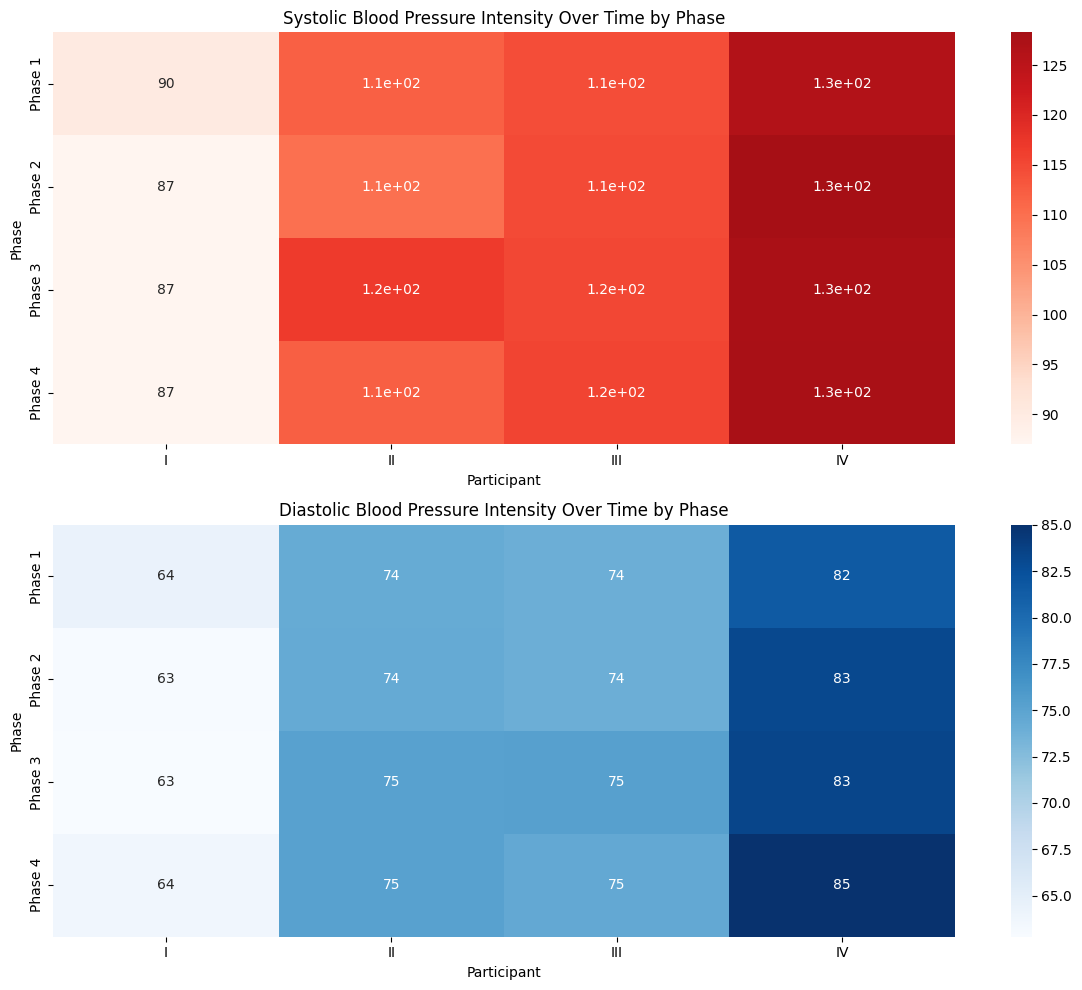

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_filled.columns = df_filled.columns.str.strip()  # Clean column names

# Define column names for each metric
systolic_bp_columns = [
    'Blood-Pressure(systolic)(mmHg)-Z', 
    'Blood-Pressure(systolic)(mmHg)-R', 
    'Blood-Pressure(systolic)(mmHg)-O', 
    'Blood-Pressure(systolic)(mmHg)-J'
]

diastolic_bp_columns = [
    'Blood-Pressure(diastolic)(mmHg)-Z', 
    'Blood-Pressure(diastolic)(mmHg)-R', 
    'Blood-Pressure(diastolic)(mmHg)-O', 
    'Blood-Pressure(diastolic)(mmHg)-J'
]

# Check if columns exist
missing_cols = [col for col in systolic_bp_columns + diastolic_bp_columns if col not in df_filled.columns]
if missing_cols:
    print(f"Warning: Missing blood pressure columns in dataset: {missing_cols}")
else:
    print("All required blood pressure columns are present.")

# Convert blood pressure columns to numeric
for col in systolic_bp_columns + diastolic_bp_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Determine the number of rows per phase (splitting equally)
num_rows = len(df_filled)
phase_size = num_rows // 4  # Assuming equal division into 4 phases

# Creating a DataFrame with phases
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phases = np.repeat(phase_labels, phase_size)

# Adjust for cases where num_rows is not a multiple of 4
if len(phases) < num_rows:
    phases = np.append(phases, ['Phase 4'] * (num_rows - len(phases)))

# Creating the DataFrame with actual blood pressure values
df_phases_systolic = pd.DataFrame({
    'Phase': phases[:num_rows],  # Ensuring correct length
    'I': df_filled['Blood-Pressure(systolic)(mmHg)-Z'],
    'II': df_filled['Blood-Pressure(systolic)(mmHg)-R'],
    'III': df_filled['Blood-Pressure(systolic)(mmHg)-O'],
    'IV': df_filled['Blood-Pressure(systolic)(mmHg)-J']
})

df_phases_diastolic = pd.DataFrame({
    'Phase': phases[:num_rows],  # Ensuring correct length
    'I': df_filled['Blood-Pressure(diastolic)(mmHg)-Z'],
    'II': df_filled['Blood-Pressure(diastolic)(mmHg)-R'],
    'III': df_filled['Blood-Pressure(diastolic)(mmHg)-O'],
    'IV': df_filled['Blood-Pressure(diastolic)(mmHg)-J']
})

# Pivot the DataFrame for heatmap
heatmap_data_systolic = df_phases_systolic.groupby('Phase').mean()
heatmap_data_diastolic = df_phases_diastolic.groupby('Phase').mean()

# Plot the heatmaps
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.heatmap(heatmap_data_systolic, cmap='Reds', annot=True, center=np.mean(heatmap_data_systolic.values))
plt.title('Systolic Blood Pressure Intensity Over Time by Phase')
plt.xlabel('Participant')
plt.ylabel('Phase')

plt.subplot(2, 1, 2)
sns.heatmap(heatmap_data_diastolic, cmap='Blues', annot=True, center=np.mean(heatmap_data_diastolic.values))
plt.title('Diastolic Blood Pressure Intensity Over Time by Phase')
plt.xlabel('Participant')
plt.ylabel('Phase')

plt.tight_layout()
plt.show()


### Glucose


### QQ plot for Glucose

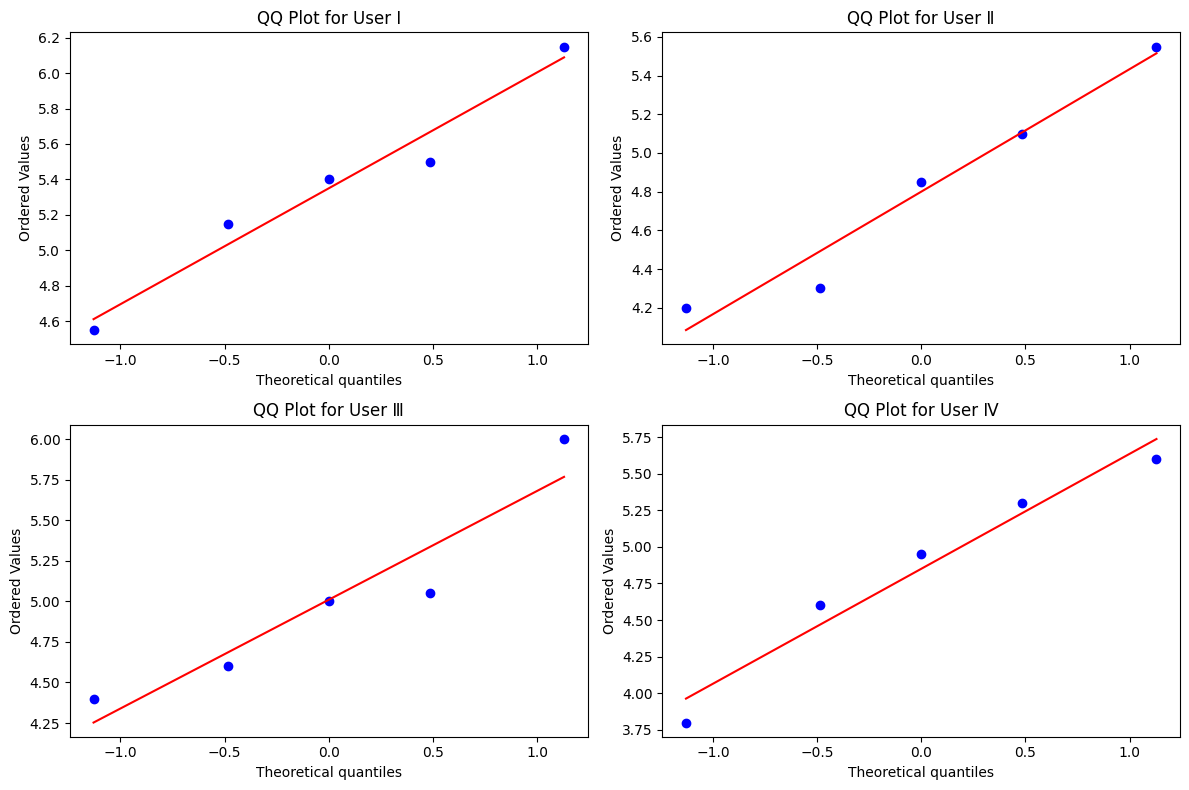

In [826]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Define column names for each metric
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['User Ⅰ', 'User Ⅱ', 'User Ⅲ', 'User Ⅳ']

plt.figure(figsize=(12, 8))


for i, (col, roman) in enumerate(zip(Glucose_columns, roman_labels), 1):
    plt.subplot(2, 2, i) 
    stats.probplot(df_Glucose[col].dropna(), dist="norm", plot=plt) 
    plt.title(f'QQ Plot for {roman}') 

plt.tight_layout()
plt.show()




In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.graph_objects as go

# Define the column names for Glucose(mmol/l)
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['User Ⅰ', 'User Ⅱ', 'User Ⅲ', 'User Ⅳ']

def create_qq_plot(columns, title):
    fig = go.Figure()

    for col, roman in zip(columns, roman_labels):
        data = pd.to_numeric(df_Glucose[col], errors='coerce').dropna()  # Ensure numeric values only
        
        if data.empty:
            print(f"Warning: No valid numeric data for {roman}, skipping.")
            continue  # Skip if no valid data
        
        # Perform Q-Q plot calculation
        osm, osr = stats.probplot(data, dist="norm")[0]  # Extract only the quantiles

        # Add scatter plot for each user
        fig.add_trace(go.Scatter(
            x=osm, 
            y=osr, 
            mode='markers', 
            name=f'QQ Plot for {roman}',
            marker=dict(size=6, opacity=0.7)
        ))

    # Add reference (y=x) line
    if fig.data:
        min_val = min(fig.data[0].x)
        max_val = max(fig.data[0].x)
    else:
        min_val, max_val = 0, 1

    fig.add_trace(go.Scatter(
        x=[min_val, max_val], 
        y=[min_val, max_val], 
        mode='lines', 
        name='Reference Line',
        line=dict(color='red', dash='dash')
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Theoretical Quantiles",
        yaxis_title="Ordered Values",
        template="plotly_white"
    )

    fig.show()

# Generate QQ plots for metric

create_qq_plot(Glucose_columns, "Interactive QQ Plot for Glucose(mmol/l)")


In [ ]:
df_Glucose.head()

,Date,Test Type,Glucose(mmol/l)-Z,Glucose(mmol/l)-R,Glucose(mmol/l)-O,Glucose(mmol/l)-J
0,11/28/2024,BaseLine-Test,4.55,4.85,4.40,3.80
1,12/9/2024,The First_Test (HalfDose),6.15,4.30,5.00,5.30
2,12/19/2024,The Second_Test fullDose),5.40,4.20,4.60,4.60
3,1/9/2025,The Second_Test (HalfDose),5.50,5.55,5.05,5.60
4,1/30/2025,The Second_Test (FullDose),5.15,5.10,6.00,4.95


In [ ]:
import pandas as pd
import plotly.express as px

# Define columns and labels
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']
print(Glucose_columns)
# Convert to numeric to avoid errors
for col in Glucose_columns:
    df_Glucose[col] = pd.to_numeric(df_Glucose[col], errors='coerce')

# Calculate means
Glucose_means = [df_Glucose[col].mean() for col in Glucose_columns]

# Create DataFrames for plotting
df_Glucose = pd.DataFrame({'Person': roman_labels, 'Glucose_level(mmol/l)': Glucose_means})

# Interactive bar plot for Heart-rate
fig2 = px.bar(df_Glucose, x='Person', y='Glucose_level(mmol/l)', text='Glucose_level(mmol/l)',
              title='Average Glucose(mmol/l) per Person', template="plotly_dark",
              color='Glucose_level(mmol/l)', color_continuous_scale='purples')

fig2.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig2.show()


['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']


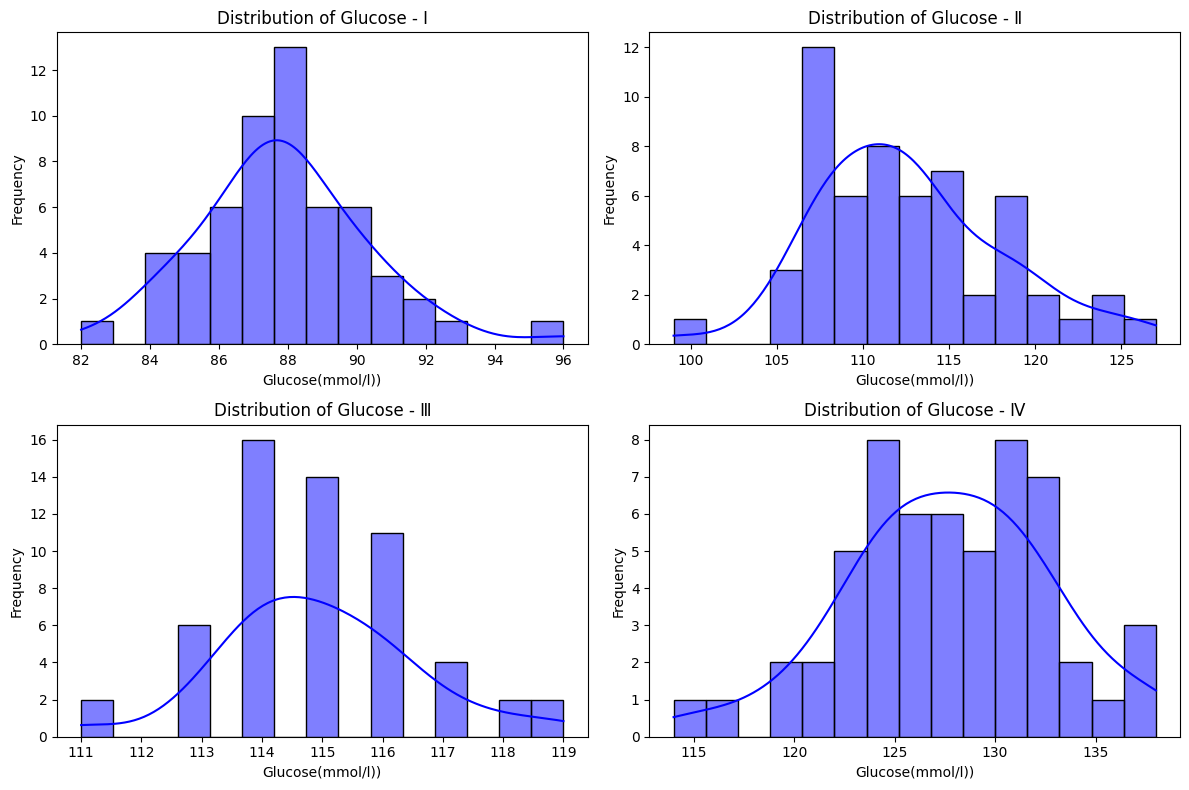

In [840]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define columns and labels
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ']

# Convert to numeric to avoid errors
for col in systolic_columns + diastolic_columns:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# 🔵 Plot Blood Pressure (Systolic)
plt.figure(figsize=(12, 8))
for i, (col, roman) in enumerate(zip(systolic_columns, roman_labels), 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filled[col], kde=True, bins=15, color='blue')
    plt.title(f'Distribution of Glucose - {roman}')
    plt.xlabel('Glucose(mmol/l))')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



### Box plot for Glucose

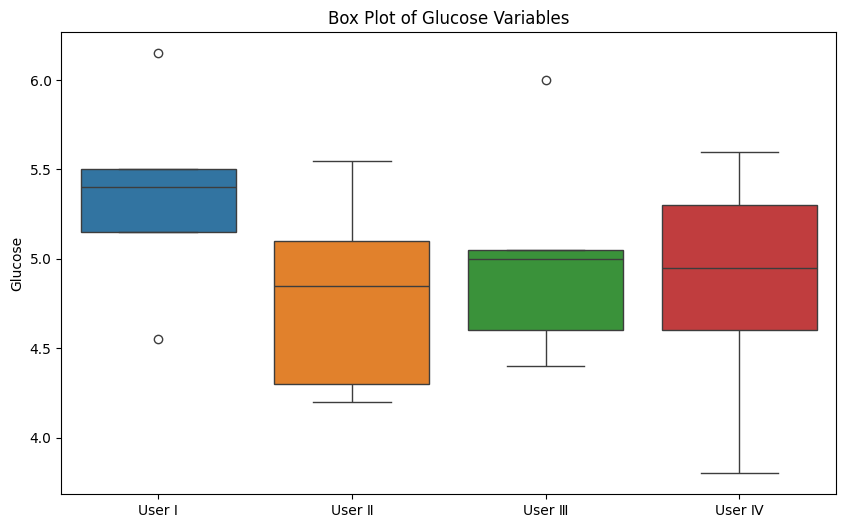

In [827]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Create a box plot for each weight column
sns.boxplot(data=df_Glucose[Glucose_columns])

# Change x-axis labels to Greek numerals
plt.xticks(ticks=range(4), labels=roman_labels)

# Add title and labels
plt.title("Box Plot of Glucose Variables")
plt.ylabel("Glucose")

# Show the plot
plt.show()

### Interactive plot for Glucose change

In [839]:
Glucose_data

0    3.80
1    5.30
2    4.60
3    5.60
4    4.95
Name: Glucose(mmol/l)-J, dtype: float64

In [841]:
import pandas as pd
import plotly.graph_objects as go
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import Output, VBox
from IPython.display import display

# Define column names for Glucose
Glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']
roman_labels = ['UserⅠ', 'UserⅡ', 'UserⅢ', 'UserⅣ']

# Extract unique time points (only 5)
date_column = df_Glucose['Date'].unique()[:5]  

fig = go.Figure()
summary_stats = []
dropdown_options = []

for i, (Glucose_col, roman) in enumerate(zip(Glucose_columns, roman_labels)):
    # Extract relevant Glucose data
    Glucose_data = pd.to_numeric(df_Glucose[Glucose_col], errors='coerce').dropna()
    aligned_dates = df_Glucose.loc[df_Glucose[Glucose_col].notna(), 'Date'].unique()[:5]  # Keep only valid dates

    # Linear regression (only if enough data)
    if len(Glucose_data) > 1:
        aligned_index = range(len(aligned_dates))  # Reindex for regression
        Glucose_slope, Glucose_intercept, _, _, _ = stats.linregress(aligned_index, Glucose_data[:5])
    else:
        Glucose_slope, Glucose_intercept = 0, Glucose_data.mean() if not Glucose_data.empty else 0

    # Summary Statistics
    summary_stats.append(
        pd.DataFrame({
            "Metric": ["Mean", "Std Dev", "Skewness", "Kurtosis", "Normality Test p-value"],
            "Glucose (mmol/l)": [Glucose_data.mean(), Glucose_data.std(), Glucose_data.skew(), 
                                 Glucose_data.kurtosis(), 
                                 stats.normaltest(Glucose_data).pvalue if len(Glucose_data) > 2 else None]
        })
    )

    # Scatter plot for Glucose (only 5 time points)
    fig.add_trace(go.Scatter(
        x=aligned_dates, 
        y=Glucose_data[:5],  
        mode='markers', 
        name=f'Glucose {roman}',
        marker=dict(size=8, opacity=0.7, color='blue'),
        visible=(i == 0)  # Only the first user is visible by default
    ))

    # Regression line for Glucose (only 5 points)
    fig.add_trace(go.Scatter(
        x=aligned_dates, 
        y=[Glucose_slope * x + Glucose_intercept for x in range(len(aligned_dates))],
        mode='lines',
        name=f'Glucose Regression {roman}',
        line=dict(dash='dash', color='blue'),
        visible=(i == 0)
    ))

    dropdown_options.append(
        dict(label=roman,
             method="update",
             args=[{"visible": [j // 2 == i for j in range(2 * len(roman_labels))]},
                   {"title": f"Scatter Plot & Regression - {roman}"}])
    )

# Update figure layout
fig.update_layout(
    title="Scatter Plot for Glucose(mmol/l)",
    xaxis_title="Date",
    yaxis_title="Glucose (mmol/l)",
    xaxis=dict(tickvals=date_column, ticktext=date_column),  # Show only 5 dates
    updatemenus=[dict(buttons=dropdown_options, direction="down", showactive=True)],
    template="plotly_white"
)

fig.show()

# **Interactive Summary Table**
# Dropdown Widget
dropdown = widgets.Dropdown(
    options=list(zip(roman_labels, range(len(roman_labels)))),
    description='User:',
    style={'description_width': 'initial'}
)

# Output Widget
out = Output()

# Function to update summary table
def update_summary(change):
    with out:
        out.clear_output(wait=True)
        display(summary_stats[change.new])

# Connect dropdown to function
dropdown.observe(update_summary, names='value')

# Show initial table
with out:
    display(summary_stats[0])

# Display Dropdown + Table
display(VBox([dropdown, out]))


C:\Users\ztahe\AppData\Local\Temp\ipykernel_4884\2768624369.py:37: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



In [843]:
df_Glucose.info

<bound method DataFrame.info of           Date                   Test Type  Glucose(mmol/l)-Z  \
0   11/28/2024               BaseLine-Test               4.55   
1    12/9/2024   The First_Test (HalfDose)               6.15   
2   12/19/2024   The Second_Test fullDose)               5.40   
3     1/9/2025  The Second_Test (HalfDose)               5.50   
4    1/30/2025  The Second_Test (FullDose)               5.15   
..         ...                         ...                ...   
66         NaN                         NaN                NaN   
67         NaN                         NaN                NaN   
68         NaN                         NaN                NaN   
69         NaN                         NaN                NaN   
70         NaN                         NaN                NaN   

    Glucose(mmol/l)-R  Glucose(mmol/l)-O  Glucose(mmol/l)-J  
0                4.85               4.40               3.80  
1                4.30               5.00               5.30  
2

### Analyze_users for Glucose


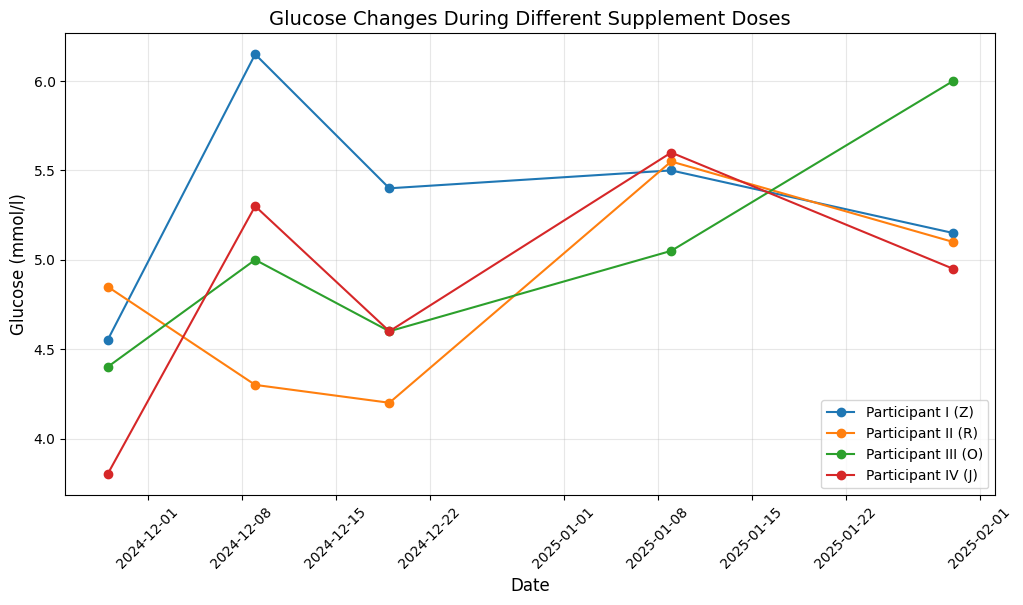

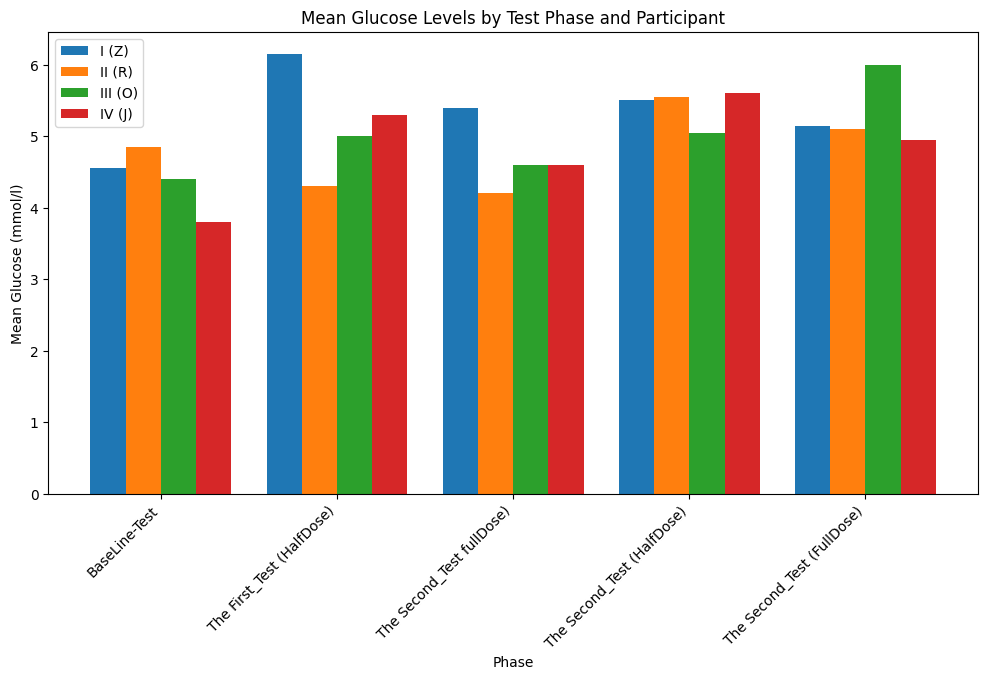

In [850]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Convert Date column to datetime format
df_Glucose['Date'] = pd.to_datetime(df_Glucose['Date'], errors='coerce')

# Convert Glucose columns to numeric, forcing errors to NaN
Glucose_Z = pd.to_numeric(df_Glucose['Glucose(mmol/l)-Z'], errors='coerce')
Glucose_R = pd.to_numeric(df_Glucose['Glucose(mmol/l)-R'], errors='coerce')
Glucose_O = pd.to_numeric(df_Glucose['Glucose(mmol/l)-O'], errors='coerce')
Glucose_J = pd.to_numeric(df_Glucose['Glucose(mmol/l)-J'], errors='coerce')

# Drop missing values
df_Glucose = df_Glucose.dropna()

# 1. **Create Line Plot for all participants**
plt.figure(figsize=(12, 6))
plt.plot(df_Glucose['Date'], Glucose_Z, label='Participant I (Z)', marker='o')
plt.plot(df_Glucose['Date'], Glucose_R, label='Participant II (R)', marker='o')
plt.plot(df_Glucose['Date'], Glucose_O, label='Participant III (O)', marker='o')
plt.plot(df_Glucose['Date'], Glucose_J, label='Participant IV (J)', marker='o')

# Customize plot
plt.title('Glucose Changes During Different Supplement Doses', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Glucose (mmol/l)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 2. **Mean Changes Plot**
means_df = pd.DataFrame({
    'Phase': df_Glucose['Test Type'],
    'Z': Glucose_Z,
    'R': Glucose_R,
    'O': Glucose_O,
    'J': Glucose_J
})

plt.figure(figsize=(12, 6))
bar_width = 0.2
r1 = np.arange(len(means_df['Phase']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.bar(r1, means_df['Z'], width=bar_width, label='I (Z)')
plt.bar(r2, means_df['R'], width=bar_width, label='II (R)')
plt.bar(r3, means_df['O'], width=bar_width, label='III (O)')
plt.bar(r4, means_df['J'], width=bar_width, label='IV (J)')

plt.xlabel('Phase')
plt.ylabel('Mean Glucose (mmol/l)')
plt.title('Mean Glucose Levels by Test Phase and Participant')

# Rotate x-axis labels
plt.xticks([r + bar_width * 1.5 for r in range(len(means_df['Phase']))], 
           means_df['Phase'], rotation=45, ha="right")

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import ipywidgets as widgets
from IPython.display import display, clear_output

# User labels corresponding to glucose readings
user_labels = ['I', 'II', 'III', 'IV']

# Define glucose columns
glucose_columns = ['Glucose(mmol/l)-Z', 'Glucose(mmol/l)-R', 
                   'Glucose(mmol/l)-O', 'Glucose(mmol/l)-J']

# Output widget to prevent duplicate outputs
output = widgets.Output()

def analyze_user_glucose(user_index):
    with output:
        clear_output(wait=True)  # Clear previous output to avoid duplication

        # Get the glucose column for the selected user
        user_glucose = glucose_columns[user_index]

        # Filter and clean the dataset
        user_data = df_Glucose[['Test Type', user_glucose]].dropna()
        user_data.rename(columns={user_glucose: 'Glucose', 'Test Type': 'Phase'}, inplace=True)
        user_data['Phase'] = user_data['Phase'].str.strip()

        # Calculate mean glucose values per phase
        mean_glucose = user_data.groupby('Phase')['Glucose'].mean()

        # ----- 1. Single Bar Chart -----
        fig, ax = plt.subplots(figsize=(10, 5))
        bars = ax.bar(mean_glucose.index, mean_glucose.values, color=['blue', 'green', 'orange', 'red'])
        ax.set_title(f'Glucose Levels - User {user_labels[user_index]}')
        ax.set_xlabel('Phase')
        ax.set_ylabel('Mean Glucose (mmol/L)')
        ax.set_xticks(range(len(mean_glucose.index)))
        ax.set_xticklabels(mean_glucose.index, rotation=45)
        ax.grid(True, alpha=0.3)

        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # ----- 2. Single Statistical Analysis -----
        print(f"\n**Statistical Analysis for User {user_labels[user_index]}**\n")

        def normality_test(data, label):
            if len(data) > 2:
                ad_result = stats.anderson(data)
                return f"{label}: Statistic = {ad_result.statistic:.4f}, Critical Value = {ad_result.critical_values[2]:.4f}, " \
                    f"Conclusion: {'Normally Distributed' if ad_result.statistic < ad_result.critical_values[2] else 'Not Normally Distributed'}"
            return f"{label}: Not enough data for Normality Test"

        print(f"📌 **Glucose (mmol/L)**")
        print(f"🔹 **Normality Test:** {normality_test(user_data['Glucose'], 'Glucose')}")

        # Variance Homogeneity Test
        phases = user_data['Phase'].unique()
        grouped_glucose = [user_data[user_data['Phase'] == phase]['Glucose'] for phase in phases if not user_data[user_data['Phase'] == phase].empty]

        def variance_test(grouped_data, label):
            if len(grouped_data) > 1:
                stat, p = stats.levene(*grouped_data, center='median')
                return f"{label}: Levene Statistic = {stat:.4f}, p-value = {p:.4f}, " \
                    f"Conclusion: {'Variance is Homogeneous' if p > 0.05 else 'Variance is NOT Homogeneous'}"
            return f"{label}: Not enough data for Variance Test"

        print(f"\n🔹 **Variance Homogeneity Test for Glucose:** {variance_test(grouped_glucose, 'Glucose')}")

# Create a dropdown widget for user selection
user_dropdown = widgets.Dropdown(
    options=list(zip(user_labels, range(len(user_labels)))),
    description='Select User:',
    style={'description_width': 'initial'}
)

# Display dropdown and connect it to the output widget
display(user_dropdown, output)
user_dropdown.observe(lambda change: analyze_user_glucose(change.new), names='value')




Dropdown(description='Select User:', options=(('I', 0), ('II', 1), ('III', 2), ('IV', 3)), style=DescriptionSt…

Output()